#**FX Quoting Strategy – Code Challenge**

**Project Description**

The task is to build a quoting model for eFX trading that:

---


- Generates bid and ask prices for liquidity levels [1, 3, 5, 10, 50, 75, 100, 150] million
- Attracts liquidity and remains competitive
- Is evaluated using market metrics like top-of-book coverage, crossing rates, spread width, and interpolation quality.

#**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy.stats import zscore
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor

**Load Data From Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Parameters/ Path definition**

In [3]:
main_path = '/content/drive/My Drive/data'
lp_quotes_path = os.path.join(main_path, 'lp_quotes/*.parquet')
trade_data_path = os.path.join(main_path, 'trade_data/bankofmontreal-e134q-09jrg4pq-trade_data.parquet')
liquidty_levels = [1, 3, 5, 10, 50, 75, 100, 150] # pre-defined in task challenge document (Unit in millions)

**Load LP Dataset**

In [4]:
def read_parquet_file(file_path):
    """ Helper function for reading a parquet file and return a DataFrame"""
    df = pd.read_parquet(file_path)
    return df

def load_quotes_data(lp_quotes_path):
    """ Load liquidity_provider_quotes.parquet files"""
    all_files = glob.glob(lp_quotes_path)
    print(all_files)
    dataframes = []
    for filename in all_files:
        df = read_parquet_file(filename)
        dataframes.append(df)
    df = pd.concat(dataframes, ignore_index=True)
    return df

#lp_quotes_path = '/content/drive/My Drive/data/lp_quotes/*.parquet'
lp_quotes = load_quotes_data(lp_quotes_path)

['/content/drive/My Drive/data/lp_quotes/bankofmontreal-e134q-6zbawtvb-2023-01-01_liquidity_provider_quotes.parquet', '/content/drive/My Drive/data/lp_quotes/bankofmontreal-e134q-m4cmkp7d-2023-01-02_liquidity_provider_quotes.parquet', '/content/drive/My Drive/data/lp_quotes/bankofmontreal-e134q-up2htt1o-2023-01-03_liquidity_provider_quotes.parquet', '/content/drive/My Drive/data/lp_quotes/bankofmontreal-e134q-j4gwk3a7-2023-01-04_liquidity_provider_quotes.parquet', '/content/drive/My Drive/data/lp_quotes/bankofmontreal-e134q-gm08e9y0-2023-01-05_liquidity_provider_quotes.parquet', '/content/drive/My Drive/data/lp_quotes/bankofmontreal-e134q-zrrpwkac-2023-01-06_liquidity_provider_quotes.parquet', '/content/drive/My Drive/data/lp_quotes/bankofmontreal-e134q-dg3opiif-2023-01-07_liquidity_provider_quotes.parquet', '/content/drive/My Drive/data/lp_quotes/bankofmontreal-e134q-ove9hasv-2023-01-08_liquidity_provider_quotes.parquet', '/content/drive/My Drive/data/lp_quotes/bankofmontreal-e134q-x1

**Load Trade Data**

In [65]:
trade_df = read_parquet_file(trade_data_path)

In [66]:
trade_df.head()


,timestamp,side,size,flag
0,2023-01-03 12:00:00,buy,100000,external
1,2023-01-04 03:50:50,buy,100000,external
2,2023-01-15 11:59:50,sell,1000000,external
3,2023-01-11 11:59:50,sell,100000,external
4,2023-01-21 11:59:50,sell,500000,external


# **Initial Data Exploration**

In [7]:
# Display the shape and info of the DataFrame
print("Shape of the DataFrame:")
print(lp_quotes.shape)
lp_quotes.info(memory_usage='deep')
lp_quotes.describe(include='all')

Shape of the DataFrame:
(9322560, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9322560 entries, 0 to 9322559
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   lp_id      int64         
 2   side       object        
 3   price      float64       
 4   size       int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 817.9 MB


,timestamp,lp_id,side,price,size
count,9322560,9.322560e+06,9322560,9.322560e+06,9.322560e+06
unique,NaN,NaN,2,NaN,NaN
top,NaN,NaN,bid,NaN,NaN
freq,NaN,NaN,4661280,NaN,NaN
mean,2023-01-11 14:59:54.999996160,2.384615e+00,NaN,1.120103e+00,4.084615e+07
min,2023-01-01 06:00:00,1.000000e+00,NaN,1.107407e+00,1.000000e+06
25%,2023-01-06 10:29:57.500000,1.000000e+00,NaN,1.118828e+00,3.000000e+06
50%,2023-01-11 14:59:55,2.000000e+00,NaN,1.120006e+00,1.000000e+07
75%,2023-01-16 19:29:52.500000,3.000000e+00,NaN,1.121339e+00,7.500000e+07
max,2023-01-21 23:59:50,5.000000e+00,NaN,1.133213e+00,1.500000e+08


In [63]:
lp_quotes.head(n=5)

,timestamp,lp_id,side,price,size
0,2023-01-01 06:00:00,1,bid,1.118249,1000000
1,2023-01-01 06:00:00,1,ask,1.118493,1000000
2,2023-01-01 06:00:00,1,bid,1.117949,3000000
3,2023-01-01 06:00:00,1,ask,1.118780,3000000
4,2023-01-01 06:00:00,1,bid,1.117816,5000000


**Optimizing Memory Usage**

The original dataset DataFrame memory usage is ~ 819MB which is a bit high for my system RAM. In order to make the memory more optimized, I write the following function to change the type of DataFrame columns in order to reduce the memory usage. The dataset memory usage after optimization reduced to 195.6 MB, indicating 75% reduction in memory usage.

In [5]:
def optimize_memory(lp_quotes):
    lp_quotes['lp_id'] = lp_quotes['lp_id'].astype('uint8') # lp_id is a small integer
    lp_quotes['side'] = lp_quotes['side'].astype('category') # side is a categorical variable
    lp_quotes['size'] = pd.to_numeric(lp_quotes['size'], downcast='unsigned')

    return lp_quotes

lp_quotes = optimize_memory(lp_quotes)
lp_quotes.info(memory_usage='deep')
lp_quotes.head(n=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9322560 entries, 0 to 9322559
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   lp_id      uint8         
 2   side       category      
 3   price      float64       
 4   size       uint32        
dtypes: category(1), datetime64[ns](1), float64(1), uint32(1), uint8(1)
memory usage: 195.6 MB


,timestamp,lp_id,side,price,size
0,2023-01-01 06:00:00,1,bid,1.118249,1000000
1,2023-01-01 06:00:00,1,ask,1.118493,1000000
2,2023-01-01 06:00:00,1,bid,1.117949,3000000
3,2023-01-01 06:00:00,1,ask,1.118780,3000000
4,2023-01-01 06:00:00,1,bid,1.117816,5000000


# **Investigating for missing values and inconsistent data**

In [6]:
def sort_timestmap_data(lp_quotes):
    "sort datasets based on timestamps (ascending order)."
    lp_quotes = lp_quotes.sort_values(by=['timestamp'], ascending=True).reset_index(drop=True)
    return lp_quotes

def check_missing_values(lp_quotes, drop_rows=False):
    """ Check for missing values in the dataset """
    missing_values = lp_quotes.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if not missing_values.empty:
        print('Missing values found:\n {missing_values}')
        if drop_rows:
            lp_quotes = lp_quotes.dropna(axis=0) # remove rows with missing values
    else:
        print ("No missing values found.")

    return lp_quotes

def check_inconsistent_quotes(lp_quotes, drop_inconsistent=True):
    """ Check for inconsistent values in the dataset """
    inconsistent_values = lp_quotes[(lp_quotes['price'] <= 0) | (lp_quotes['size'] <= 0)] # check negative or zero values in price and size columns
    if not inconsistent_values.empty:
        print(f"Inconsistent data found.")
        if drop_inconsistent:
            lp_quotes = lp_quotes.drop(inconsistent_values.index)

    else:
        print("No inconsistent values found.")

    return lp_quotes

def check_unique_values(lp_quotes, valid_lp_ids, valid_sides):
    """ Check for unique values LP_ID and Side colmuns in the dataset """
    unique_lp_ids = lp_quotes['lp_id'].unique()
    unique_sides = lp_quotes['side'].unique()

    if valid_lp_ids is not None:
        invalid_lp_ids = [lp_id for lp_id in unique_lp_ids if lp_id not in valid_lp_ids]
        if invalid_lp_ids:
            print(f"Invalid LP_IDs found: {invalid_lp_ids}")
            lp_quotes = lp_quotes[~lp_quotes['lp_id'].isin(invalid_lp_ids)]

    if valid_sides is not None:
        invalid_sides = [side for side in unique_sides if side not in valid_sides]
        if invalid_sides:
            print(f"Invalid side values found: {invalid_sides}")
            lp_quotes = lp_quotes[~lp_quotes['side'].isin(invalid_sides)]
    return lp_quotes


def check_duplciate_rows(lp_quotes, keep_first=True):
    """ Check for duplicate rows in the dataset """
    duplicated_rows = lp_quotes.duplicated().sum()
    if duplicated_rows > 0:
        if keep_first:
            lp_quotes = lp_quotes.drop_duplicates(keep='first')
        else:
            lp_quotes = lp_quotes.drop_duplicates(keep='last')
    else:
        print ("No duplicated rows found.")

    return lp_quotes

def handle_missing_inconsistent_values(lp_quotes, valid_lp_ids, valid_sides):
    # sort timestamps
    lp_quotes = sort_timestmap_data(lp_quotes)
    # Check for missing values
    lp_quotes = check_missing_values(lp_quotes, drop_rows=True)
    # Check for inconsistent values
    lp_quotes = check_inconsistent_quotes(lp_quotes, drop_inconsistent=True)
    # Check for unique values
    lp_quotes = check_unique_values(lp_quotes, valid_lp_ids, valid_sides)
    # Check for duplicated rows
    lp_quotes = check_duplciate_rows(lp_quotes, keep_first=True)

    return lp_quotes

valid_lp_ids = [1, 2, 3, 4, 5]
valid_sides = ["bid", "ask"]
lp_quotes = handle_missing_inconsistent_values(lp_quotes, valid_lp_ids, valid_sides)


No missing values found.
No inconsistent values found.
No duplicated rows found.


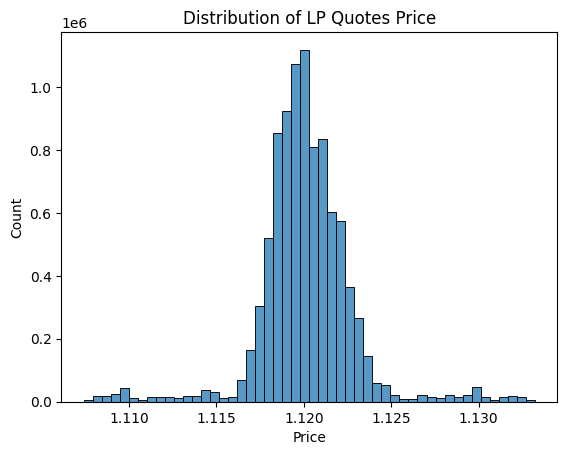

In [18]:
sns.histplot(lp_quotes['price'], bins=50, kde=False)
plt.title('Distribution of LP Quotes Price')
plt.xlabel('Price')
plt.show()

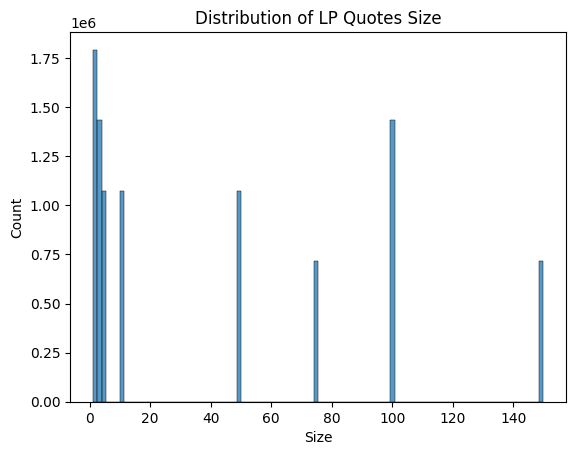

In [19]:
sns.histplot(lp_quotes['size']/1e6, bins=100, kde=False)
plt.title('Distribution of LP Quotes Size')
plt.xlabel('Size')
plt.show()

**Outlier Detection**

Due to the possibility of outliers in price distributions, I implemented a function to detect them and remove them. The function is able to process outlier detection using two methods: ZScore and IQR. As the distribution of the price follows a Normal-like distribution, Zscore is a more appropriate choice for this dataset.
Regarding size values, because the values are considered in a certain buckets and it has a discrete distribution, there is no need to outlier detection.

<Axes: xlabel='price', ylabel='Count'>

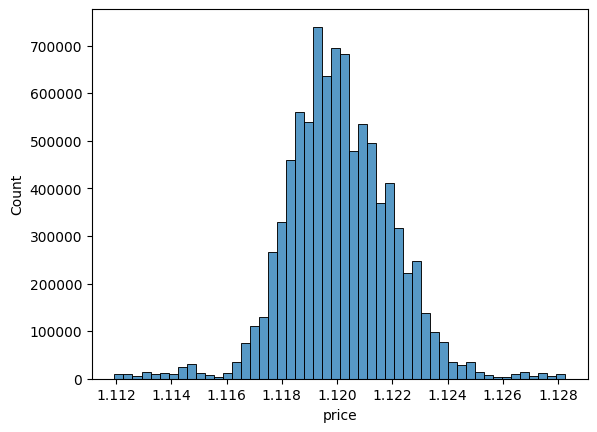

In [7]:
def handling_price_outliers(df, price_col, method, threshold=3):
    """ Detect outliers in price column in dataset. Remove them based on selected methods: IQR or Zscore """
    df = df.copy()
    if method=='zscore':
        # Z-score Based Outlier Detection for Price (because of its normal-like distribution)
        df['zscore_price'] = zscore(df[price_col])
        df['price_outlier'] = abs(df['zscore_price']) > threshold

    elif method =='IQR':
        # IQR-Based Outlier Detection for Size
        q1 = df[price_col].quantile(0.25)
        q3 = df[price_col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df['price_outlier']  = (df[price_col] > upper_bound) | (df[price_col] < lower_bound)
    else:
        raise ValueError("Invalid method. Use 'zscore' or 'IQR'.")
    # Remove outliers from the DataFrame
    df_clean = df[~df['price_outlier']].copy()
    return df_clean

df_clean = handling_price_outliers(lp_quotes, price_col='price', method='zscore', threshold=3) # selected zscore with threshold=3
sns.histplot(df_clean['price'], bins=50, kde=False)


# **Exploratory Data Analysis (EDA)**

In this section, I perform EDA tog et inisghts from dataset, paramters distribution and their correlation. EDA is critical in data science problems, before getting deep in to designing models and further analysis.

Daily Quotes Number Visualization

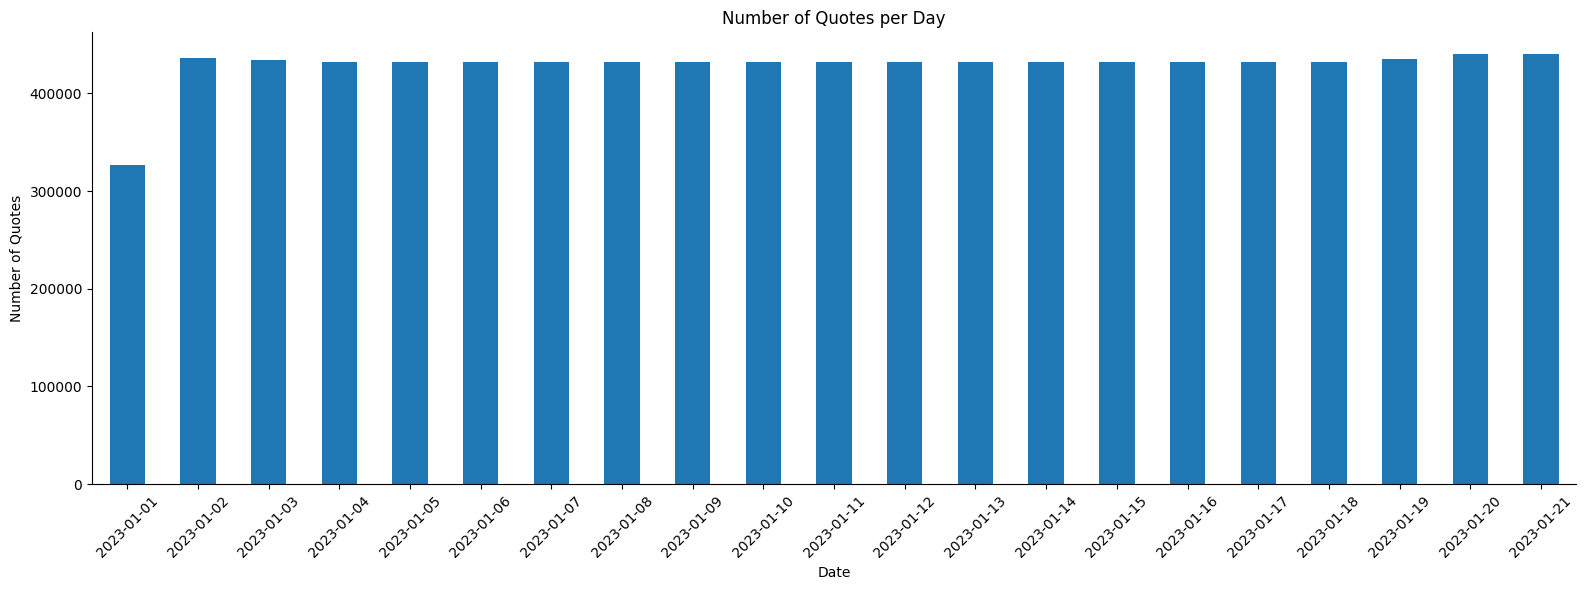

In [11]:
def plot_daily_quotes(df):
    quotes_daily = df.groupby(df['timestamp'].dt.date)
    quotes_count = quotes_daily.size()
    fig, ax = plt.subplots(1, 1, figsize=(16,6))
    quotes_count.plot(kind='bar', ax=ax, ylabel='Number of Quotes', xlabel='Date', title='Number of Quotes per Day')
    plt.xticks(rotation=45)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.show()
plot_daily_quotes(df_clean)

Number of Quotes Across Sizes and LPs

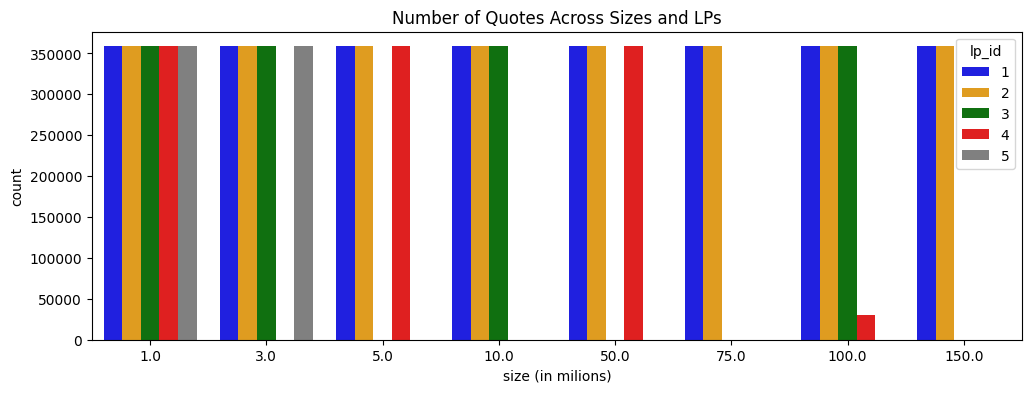

In [22]:
def plot_quote_size(df):
    df = df.copy()
    df['size'] = df['size'] / 1e6
    df_size_counts = df.groupby(['lp_id', 'size']).size().reset_index(name="count")
    plt.figure(figsize=(12,4))
    sns.barplot(data=df_size_counts, x='size', y='count', hue='lp_id', palette=['blue', 'orange', 'green', 'red', 'gray'])
    plt.title("Number of Quotes Across Sizes and LPs")
    plt.xlabel('size (in milions)')
    plt.tight_layout
    plt.show()
plot_quote_size(df_clean)

We see that some liquid providers did not offer quotes for some levels, specifically, in larger sizes, which is possible because it comes with more risk. Only LP_ID=1 and 2 offered quotes for any levels. LP_ID=5 only provided quotes for two lowest sizes.
Additionally, it can be indicated the number of quotes are imbalanced across sizes, which might be problematic.

Price Distribution

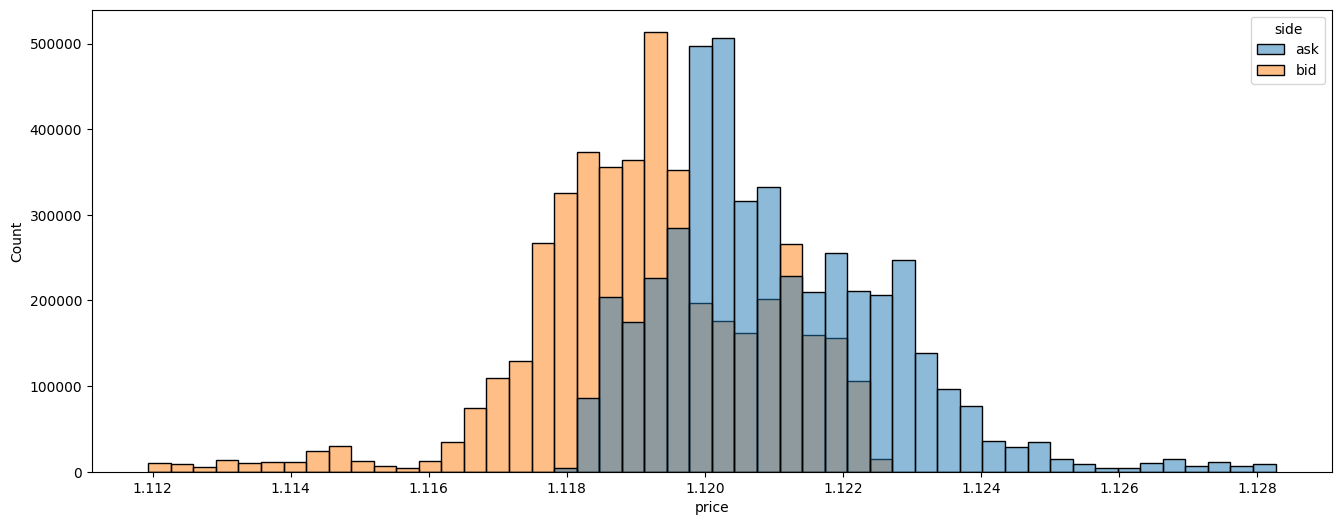

In [23]:
def plot_price_distribution(df):
    fig, ax = plt.subplots(1, 1, figsize=(16,6))
    sns.histplot(data=df, x='price', hue='side', bins=50, ax=ax, kde=False)
    plt.show()
plot_price_distribution(df_clean)

It looks like that the distribution of ask and bid prices is slightly skewed in the opposite direction.

Bid and Ask Prices for Individual LPs

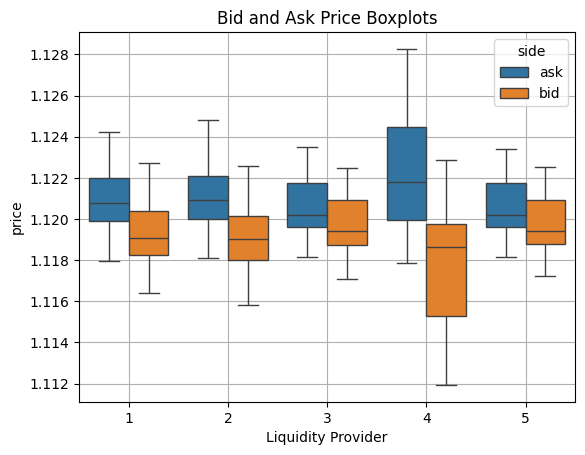

In [24]:
def visualize_price_lp(df):
    sns.boxplot(data=df, x='lp_id', y='price', hue='side')
    plt.title('Bid and Ask Price Boxplots')
    plt.xlabel('Liquidity Provider')
    plt.grid(True)
    plt.show()
visualize_price_lp(df_clean)

It looks like that distribution of bid and price values for LP_ID=4 is different than other LPs.

Price vs Size Visualization

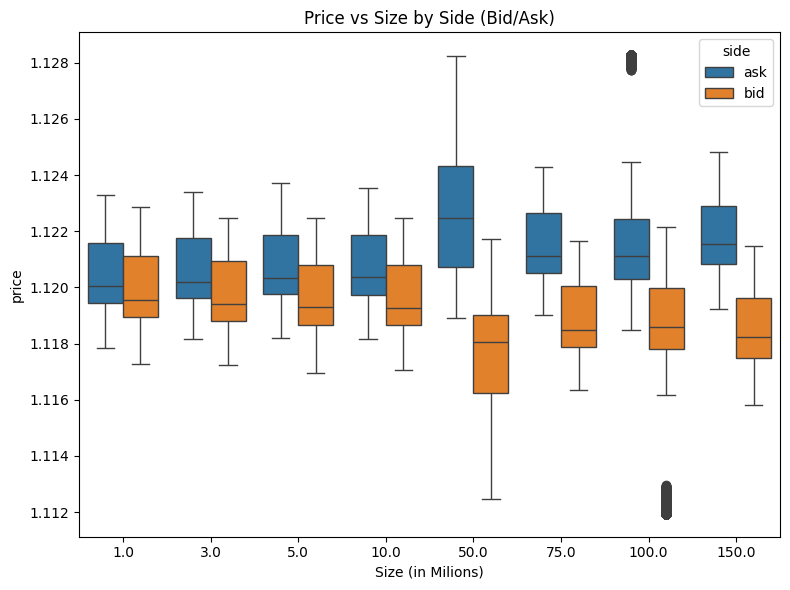

In [25]:
def plot_box_price_size(df):
    df = df.copy()
    df['size'] = df['size'] / 1e6
    plt.figure(figsize=(8,6))
    sns.boxplot(data=df, x='size', y='price', hue='side')
    plt.title('Price vs Size by Side (Bid/Ask)')
    plt.xlabel('Size (in Milions)')
    plt.tight_layout()
    plt.show()

plot_box_price_size(df_clean)

We see that in high size quotes, there is signficant difference in the distribution of bid and ask prices, which is predictable in high size eFx. Additionally, There are high number of outliers can bee seen in the level of 100M. These values might affect on the model performance and should be handled, efficiently.

**Visualizing Bid and Ask Prices Over Time**

<ipython-input-10-06218d7b478f>:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df.pivot_table(


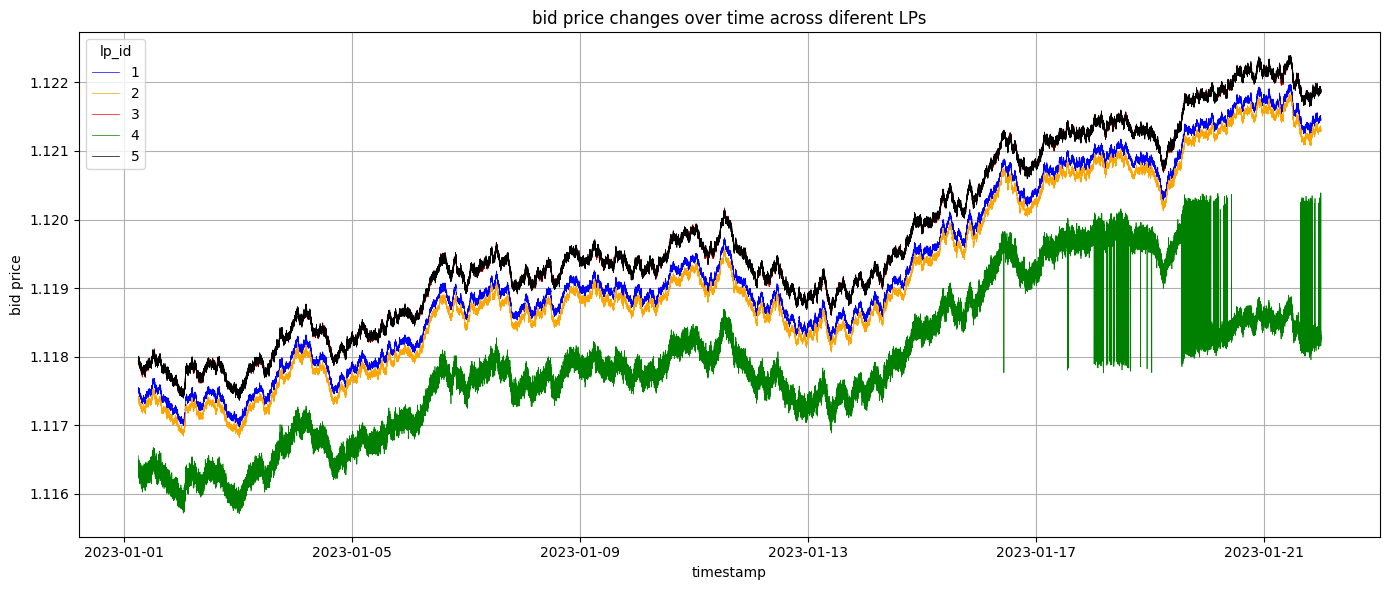

<ipython-input-10-06218d7b478f>:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df.pivot_table(


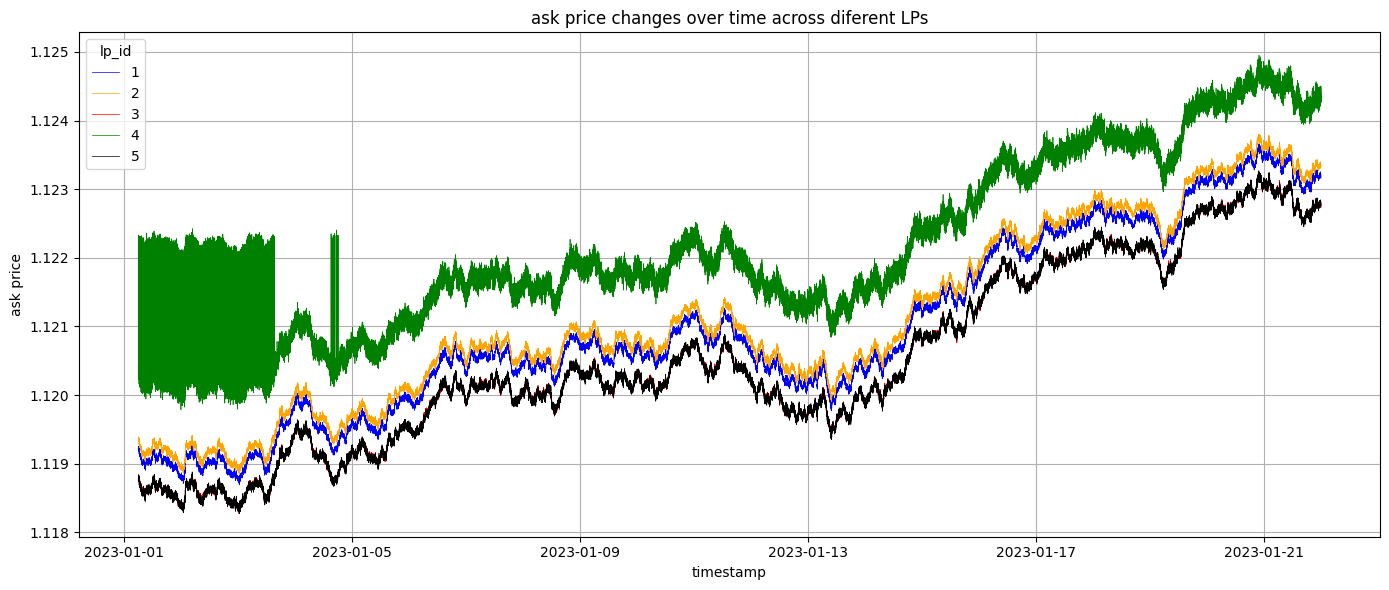

In [10]:
def plot_price_over_time(df, side):

    pivot_df = df.pivot_table(
        index = ['timestamp', 'lp_id'],
        columns='side',
        values='price',
        aggfunc='mean'
    ).reset_index() # considred average bid/ ask prices across each LP and timestamp

    plt.figure(figsize=(14,6))
    sns.lineplot(data=pivot_df, x='timestamp', y=side, hue='lp_id', palette=['blue', 'orange', 'red', 'green', 'black'], linewidth=.5)
    plt.title(f"{side} price changes over time across diferent LPs")
    plt.ylabel(f"{side} price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_price_over_time(df_clean, side='bid')
plot_price_over_time(df_clean, side='ask')

It can be inferred that for LP_ID=4, certain noisy and spiky data are observed which needs to be handled, efficiently. Additionally, the bid and ask prices in LP_ID=3 and 5 are very similiar to each other. This may cause to impact in the model performance.

**Price Time Series Denoising**

From previous figure, I believe the noisy and spiky data in LP_ID=4 prices would be problematic. Thus, I preformed time series outlier removal and smoothing. For outlier removal, I used Z-scoring with THresholld=2. Then, I applied simple moving average filter with window ~ 5min to reach a smooth version of prices.

In [8]:
def remove_outliers_by_price_zscore(df, lp_id, threshold=2.0, window=5):
    """
    Remove bid and ask outliers for a given LP based on daily z-scoring of price.

    Parameters:
    - df: full quote DataFrame with columns ['timestamp', 'lp_id', 'side', 'price']
    - lp_id: the LP to apply filtering to
    - threshold: z-score threshold for identifying outliers

    Returns:
    - df_cleaned: DataFrame with outlier quotes removed for the specified LP
    - outlier_rows: DataFrame of the removed outliers
    """

    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    # Isolate LP quotes and compute daily z-score
    df_lp = df[df['lp_id'] == lp_id].copy()
    stats = (
        df_lp.groupby(['date', 'side'])['price']
        .agg(['mean', 'std'])
        .reset_index()
        .rename(columns={'mean': 'daily_mean', 'std': 'daily_std'})
    )
    df_lp = df_lp.merge(stats, on=['date', 'side'], how='left')
    df_lp['zscore'] = (df_lp['price'] - df_lp['daily_mean']) / df_lp['daily_std']

    # Remove outliers using z-scoring criteria
    clean_lp = df_lp[df_lp['zscore'].abs() <= threshold].copy()

    # Apply moving average smoothing
    clean_lp = clean_lp.sort_values(by='timestamp')
    clean_lp['price'] = (
        clean_lp.groupby('side')['price']
        .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    )

    # Combine with rest of LPs
    df_others = df[df['lp_id'] != lp_id]
    df_smoothed = pd.concat([df_others, clean_lp], ignore_index=True)
    df_smoothed = df_smoothed.sort_values(by='timestamp')
    df_smoothed = df_smoothed[['timestamp', 'lp_id', 'side', 'price', 'size']]
    return df_smoothed

df_preprocessed = remove_outliers_by_price_zscore(df_clean, lp_id=4, threshold=2, window=31) # useed zscoring with threshold=2 and moving average with ~5min window.

<ipython-input-8-0baf0b6fbf3c>:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_lp.groupby(['date', 'side'])['price']
<ipython-input-8-0baf0b6fbf3c>:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clean_lp.groupby('side')['price']


**Visualizing Prices After Denoising**

In [9]:
plot_price_over_time(df_preprocessed, side='bid')
plot_price_over_time(df_preprocessed, side='ask')

NameError: name 'plot_price_over_time' is not defined

# **LP Classification**

**Metrics Defintions for LP Ranking**

The following metrics are defined for each LP that will be used for ranking and classifying LPs:
    - Spread: The difference between Ask and Bid pice. Usually, it's the difference between maximum bid and minimum ask, however in the dataset, we have multiple values for ask and bid, and using min and max results in getting negative values for some timestamps. In this case, I used the difference between average bid and ask prices. Then it's overall mean and standard deviation extracted.
    - Active presence in the market: Defined as average of number of quotes across timestamps.
    - Average Size: Defined as the average of liquidiy levels.
    - Quote coverage ratio: Defined as the number of full quotes (inc bid and ask).

In [52]:
def compute_spread(df):
    df = df.copy()
    lp_spread_df = df.pivot_table(
    index = ['timestamp', 'lp_id'],
    columns='side',
    values='price',
    aggfunc='mean'
    ).reset_index() # Used average of bid and ask prices to prevent from negative spreads as there are multiple prices for each bid and ask at certain timestamp

    lp_spread_df['spread'] = lp_spread_df['ask'] - lp_spread_df['bid']
    return lp_spread_df

def compute_spread_stat(lp_spread_df):
    lp_spread_df = lp_spread_df.copy()
    spread_stats = (
        lp_spread_df.groupby('lp_id')['spread']
        .agg(avg_spread='mean', spread_std='std')
        .reset_index()
    )
    return spread_stats

def active_market_analysis(df):
    df = df.copy()
    quote_counts = df.groupby('lp_id')['timestamp'].count().reset_index(name='quote_count')
    return quote_counts

def compute_avg_size(df):
    df = df.copy()
    avg_size = df.groupby('lp_id')['size'].mean().reset_index(name='avg_size')
    return avg_size

def compute_bid_ask_symmetry(df):
    bid_counts = df[df['side'] == 'bid'].groupby('lp_id').size().reset_index(name='bid_count')
    ask_counts = df[df['side'] == 'ask'].groupby('lp_id').size().reset_index(name='ask_count')

    symmetry = pd.merge(bid_counts, ask_counts, on='lp_id', how='outer').fillna(0)

    symmetry['bid_ask_symmetry'] = 1 - (
        abs(symmetry['bid_count'] - symmetry['ask_count']) /
        (symmetry['bid_count'] + symmetry['ask_count'])
    )

    return symmetry[['lp_id', 'bid_ask_symmetry']]

def compute_quote_coverage_ratio(df):
    total_timestamps = df['timestamp'].nunique()

    coverage = df.groupby(['lp_id', 'timestamp'])['side'].nunique().reset_index()
    coverage = coverage[coverage['side'] == 2]  # Only timestamps where both bid and ask are present

    quote_coverage = coverage.groupby('lp_id').size().reset_index(name='covered_timestamps')
    quote_coverage['quote_coverage_ratio'] = quote_coverage['covered_timestamps'] / total_timestamps

    return quote_coverage[['lp_id', 'quote_coverage_ratio']]

def compute_lp_metrics(df):

    lp_spread_df = compute_spread(df)
    spread_stats = compute_spread_stat(lp_spread_df)
    quote_counts = active_market_analysis(df)
    avg_size = compute_avg_size(df)
    quote_coverage = compute_quote_coverage_ratio(df)
    metrics = quote_counts.merge(avg_size, on='lp_id').merge(spread_stats, on='lp_id').merge(quote_coverage, on='lp_id')
    return metrics

lp_metrics = compute_lp_metrics(df_preprocessed)
lp_metrics.head()


<ipython-input-52-74de08c49a29>:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  lp_spread_df = df.pivot_table(


,lp_id,quote_count,avg_size,avg_spread,spread_std,quote_coverage_ratio
0,1,2868480,4.925000e+07,0.001665,0.000071,1.0
1,2,2868480,4.925000e+07,0.001966,0.000071,1.0
2,3,1434240,2.850000e+07,0.000823,0.000070,1.0
3,4,1097057,2.025151e+07,0.004195,0.000653,1.0
4,5,717120,2.000000e+06,0.000820,0.000068,1.0


**Scoring LPs Using Weighted Averaging**

I used weighted average for creating quantitaive analysis of LP ranking. I considered highest weight for active presence metric as a key indicator of an LP’s reliability. Additionally, I think that size is another important metric which is essential for minimizing market impact. Based on my research Narrow Spread is stilli mportant however, it must be backed by real size and frequency. While I computed compute_quote_coverage_ratio as another metrics for evaluating number of full quotes, but as the values are relative similiar, I didn't consider any weight for it.

In [54]:
def compute_lp_score(df):
    df = df.copy()

    # Normalizing all metrics using Min-Max scaling
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(df[['quote_count', 'avg_size', 'avg_spread', 'spread_std']])
    df_norm = pd.DataFrame(normalized, columns=['quote_count_norm', 'avg_size_norm', 'avg_spread_norm', 'spread_std_norm'])

    # Inverting the spread metrics (since lower is better)
    df_norm['avg_spread_norm'] = 1 - df_norm['avg_spread_norm']
    df_norm['spread_std_norm'] = 1 - df_norm['spread_std_norm']

    weights = {
        'quote_count_norm': 0.35, # indicator of active presence
        'avg_size_norm': 0.30, # indicator of market impact
        'avg_spread_norm': 0.25, # indicator of average cost of traing
        'spread_std_norm': 0.1   # iddicator for fluctuation in trading cost
    }

    # Computing weighted LP score
    df['lp_score'] = (
        weights['quote_count_norm'] * df_norm['quote_count_norm'] +
        weights['avg_size_norm'] * df_norm['avg_size_norm'] +
        weights['avg_spread_norm'] * df_norm['avg_spread_norm'] +
        weights['spread_std_norm'] * df_norm['spread_std_norm']
    )

    return df

lp_metrics_scored = compute_lp_score(lp_metrics)
lp_metrics_scored = lp_metrics_scored.sort_values(by='lp_score', ascending=False)
lp_metrics_scored.head()

,lp_id,quote_count,avg_size,avg_spread,spread_std,quote_coverage_ratio,lp_score
0,1,2868480,4.925000e+07,0.001665,0.000071,1.0,0.936963
1,2,2868480,4.925000e+07,0.001966,0.000071,1.0,0.914639
2,3,1434240,2.850000e+07,0.000823,0.000070,1.0,0.634356
4,5,717120,2.000000e+06,0.000820,0.000068,1.0,0.350000
3,4,1097057,2.025151e+07,0.004195,0.000653,1.0,0.177694


#**LP Quote Analytics**

**Building Consolidated Order Book**

In [41]:
def build_consolidated_order_book(df, levels=5):
    """
    Create a consolidated order book from LP quotes. Returns top N bid/ask prices and sizes per timestamp.
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Split and sort bid/ask
    bids = df[df['side'] == 'bid'].sort_values(['timestamp', 'price'], ascending=[True, False])
    asks = df[df['side'] == 'ask'].sort_values(['timestamp', 'price'], ascending=[True, True])

    # Select top N price levels per timestamp
    top_bids = bids.groupby(['timestamp', 'price'], sort=False)['size'].sum().groupby(level=0).head(levels).reset_index()
    top_asks = asks.groupby(['timestamp', 'price'], sort=False)['size'].sum().groupby(level=0).head(levels).reset_index()

    # Aggregate prices and sizes into lists
    agg_bids = top_bids.groupby('timestamp').agg(
        bid_prices=('price', lambda x: list(x)),
        bid_sizes=('size', lambda x: list(x))
    )

    agg_asks = top_asks.groupby('timestamp').agg(
        ask_prices=('price', lambda x: list(x)),
        ask_sizes=('size', lambda x: list(x))
    )

    # Merge bid and ask sides
    consolidated = agg_bids.join(agg_asks, how='outer').reset_index()

    return consolidated

order_book = build_consolidated_order_book(df_preprocessed, levels=5)

In [58]:
order_book.head()

,timestamp,bid_prices,bid_sizes,ask_prices,ask_sizes
0,2023-01-01 06:00:00,"[1.11843093, 1.11824887, 1.11814809, 1.1180840...","[1000000, 1000000, 5000000, 1000000, 1000000]","[1.11829862, 1.11849252, 1.118593045, 1.118643...","[1000000, 1000000, 5000000, 1000000, 1000000]"
1,2023-01-01 06:00:10,"[1.11825039, 1.11807657, 1.1180388, 1.11802464...","[1000000, 1000000, 3000000, 1000000, 1000000]","[1.11853036, 1.11860182, 1.11863286, 1.1187123...","[1000000, 1000000, 1000000, 1000000, 3000000]"
2,2023-01-01 06:00:20,"[1.11821506, 1.11810199, 1.11807055, 1.1180573...","[1000000, 1000000, 1000000, 3000000, 1000000]","[1.11847767, 1.11866131, 1.11870367, 1.1187301...","[1000000, 1000000, 1000000, 1000000, 10000000]"
3,2023-01-01 06:00:30,"[1.11824527, 1.11805896, 1.11804217, 1.1180343...","[1000000, 1000000, 1000000, 3000000, 1000000]","[1.11852404, 1.11866949, 1.11867993, 1.1186953...","[1000000, 1000000, 1000000, 1000000, 10000000]"
4,2023-01-01 06:00:40,"[1.11823627, 1.11810287, 1.11805754, 1.1180444...","[1000000, 1000000, 1000000, 1000000, 10000000]","[1.11853803, 1.11865877, 1.11869245, 1.1187062...","[1000000, 1000000, 3000000, 1000000, 1000000]"


In [40]:
order_book.to_pickle('/content/drive/My Drive/order_book.pkl')

NameError: name 'order_book' is not defined

**Behavioral and Trend Analytics**

In [60]:
def prepare_time_feature(df):
    """" Helpfer function for extracting timestamps information."""
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['second'] = df['timestamp'].dt.second
    df['time_bin'] = pd.to_datetime(df['timestamp']).dt.floor('30min')
    return df

def mid_price_compute(df):
    """ Build Mid price based on maximum Bid and minimum Ask values."""
    best_bid = df[df['side'] == 'bid'].groupby('timestamp')['price'].max()
    best_ask = df[df['side'] == 'ask'].groupby('timestamp')['price'].min()
    mid_price = (best_bid + best_ask) / 2
    return mid_price.reset_index(name='mid_price')

def spread_compute(df):
    """ Build Mid price based on maximum Bid and minimum Ask values."""
    avg_bid = df[df['side'] == 'bid'].groupby('timestamp')['price'].max()
    avg_ask = df[df['side'] == 'ask'].groupby('timestamp')['price'].min()
    spread = avg_ask - avg_bid
    return spread.reset_index(name='spread')

**Aggregated Analytics**

Analyzing intraday trends...


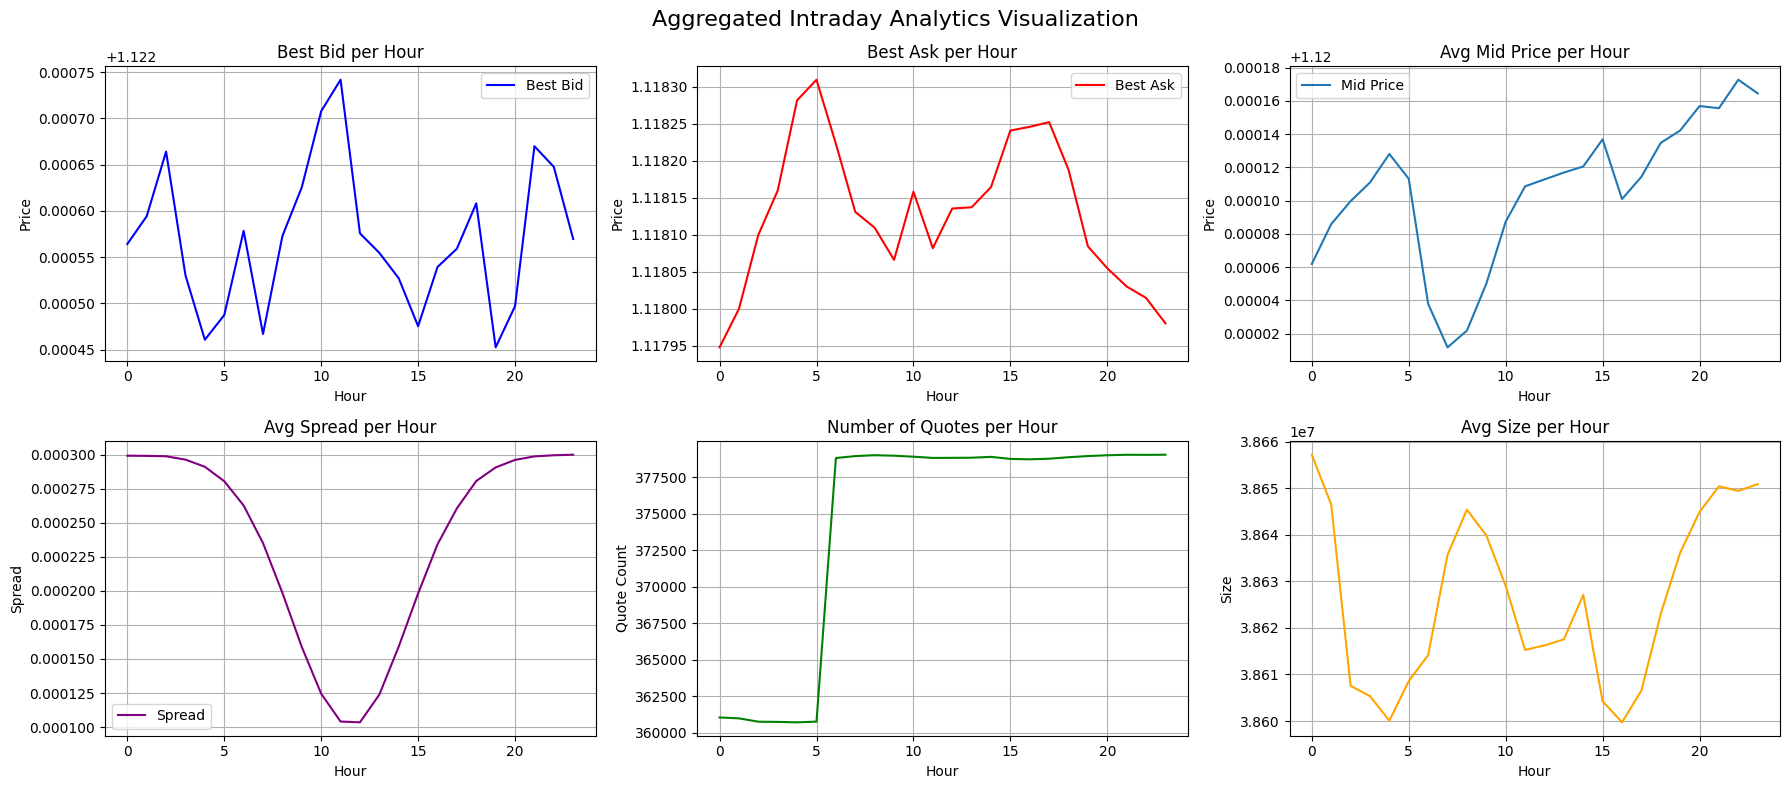

Analyzing daily trends...


<ipython-input-61-8af9b8caba21>:115: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1, 0].legend()


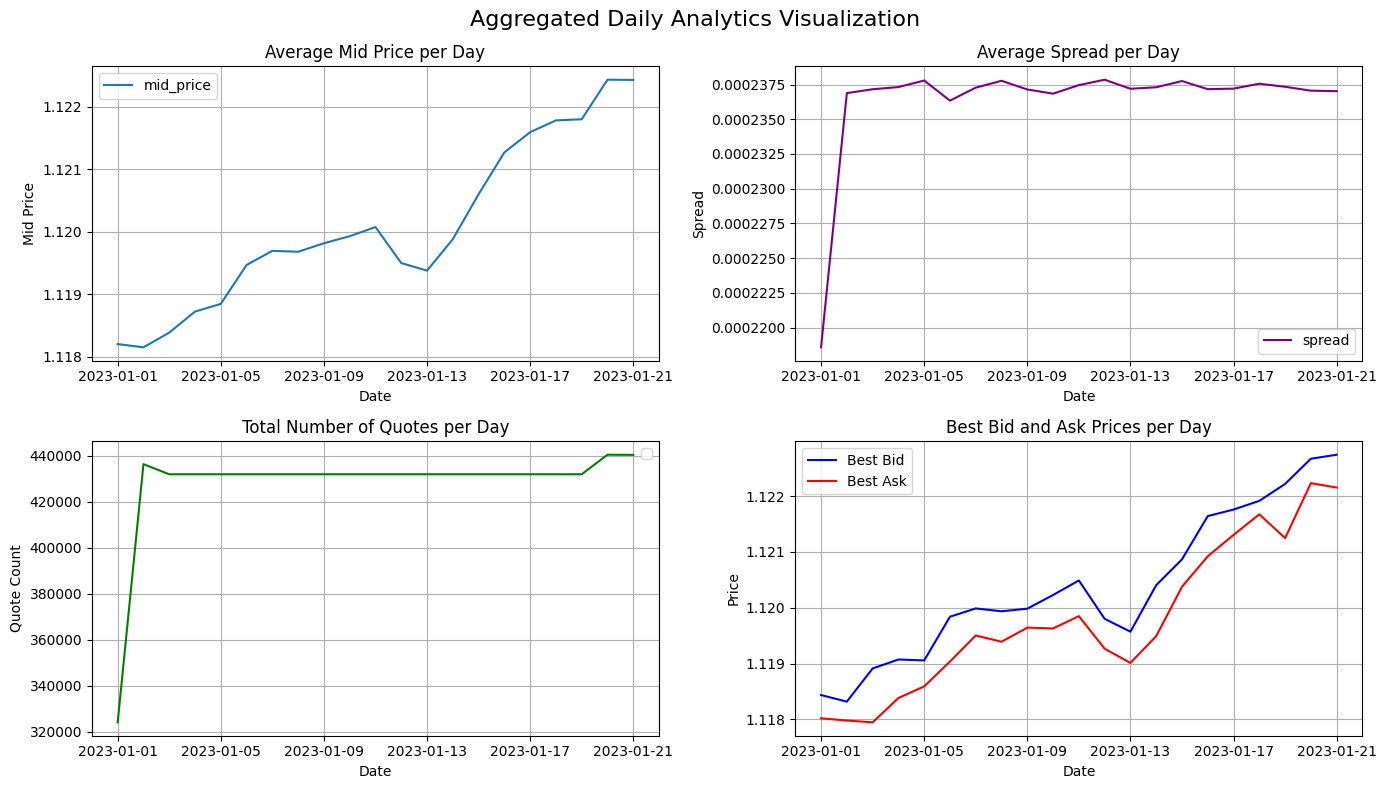

In [61]:
def analyze_intraday_trends(df):
    """ Derive intraday trends visualization"""
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour # investigated hourly changes for intraday analysis
    stats_mid = df.groupby('hour')['mid_price'].agg(['mean', 'std']).reset_index()
    stats_spread = df.groupby('hour')['spread'].agg(['mean', 'std']).reset_index()
    quote_counts = df.groupby('hour').size()
    avg_sizes = df.groupby('hour')['size'].mean()
    best_bid = (
        df[df['side'] == 'bid']
        .groupby('hour')['price']
        .max()
        .reset_index(name='best_bid')
    )

    best_ask = (
        df[df['side'] == 'ask']
        .groupby('hour')['price']
        .min()
        .reset_index(name='best_ask')
    )

    # Plot
    fig, ax = plt.subplots(2, 3, figsize=(18, 8))

    ax[0, 0].plot(best_bid['hour'], best_bid['best_bid'], label='Best Bid', color='blue')
    ax[0, 0].set_title('Best Bid per Hour')
    ax[0, 0].set_xlabel('Hour')
    ax[0, 0].set_ylabel('Price')
    ax[0, 0].legend()
    ax[0, 0].grid(True)

    ax[0, 1].plot(best_ask['hour'], best_ask['best_ask'], label='Best Ask', color='red')
    ax[0, 1].set_title('Best Ask per Hour')
    ax[0, 1].set_xlabel('Hour')
    ax[0, 1].set_ylabel('Price')
    ax[0, 1].legend()
    ax[0, 1].grid(True)

    ax[0, 2].plot(stats_mid['hour'], stats_mid['mean'], label='Mid Price')
    ax[0, 2].set_title('Avg Mid Price per Hour')
    ax[0, 2].set_xlabel('Hour')
    ax[0, 2].set_ylabel('Price')
    ax[0, 2].legend()
    ax[0, 2].grid(True)

    ax[1, 0].plot(stats_spread['hour'], stats_spread['mean'], label='Spread', color='purple')
    ax[1, 0].set_title('Avg Spread per Hour')
    ax[1, 0].set_xlabel('Hour')
    ax[1, 0].set_ylabel('Spread')
    ax[1, 0].legend()
    ax[1, 0].grid(True)

    quote_counts.plot(kind='line', ax=ax[1, 1], title='Number of Quotes per Hour', color='green')
    ax[1, 1].set_xlabel('Hour')
    ax[1, 1].set_ylabel('Quote Count')
    ax[1, 1].grid(True)

    avg_sizes.plot(kind='line', ax=ax[1, 2], title='Avg Size per Hour', color='orange')
    ax[1, 2].set_xlabel('Hour')
    ax[1, 2].set_ylabel('Size')
    ax[1, 2].grid(True)

    # Title and layout
    fig.suptitle('Aggregated Intraday Analytics Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()

def analyze_daily_trends(df):
    """ Derive daily trends visualization"""
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date

    daily_mid = df.groupby('date')['mid_price'].mean()
    daily_spread = df.groupby('date')['spread'].mean()
    quote_counts = df.groupby('date').size()
    daily_sizes = df.groupby('date')['size'].mean()

    best_bid = (
        df[df['side'] == 'bid']
        .groupby('date')['price']
        .max()
        .reset_index(name='best_bid')
    )

    best_ask = (
        df[df['side'] == 'ask']
        .groupby('date')['price']
        .min()
        .reset_index(name='best_ask')
    )

    best_quotes = best_bid.merge(best_ask, on='date')

    fig, ax = plt.subplots(2, 2, figsize=(14, 8))

    daily_mid.plot(title='Average Mid Price per Day', ax=ax[0, 0])
    ax[0, 0].set_xlabel('Date')
    ax[0, 0].set_ylabel('Mid Price')
    ax[0, 0].legend()
    ax[0, 0].grid(True)

    daily_spread.plot(title='Average Spread per Day', ax=ax[0, 1], color='purple')
    ax[0, 1].set_xlabel('Date')
    ax[0, 1].set_ylabel('Spread')
    ax[0, 1].legend()
    ax[0, 1].grid(True)

    quote_counts.plot(title='Total Number of Quotes per Day', ax=ax[1, 0], color='green')
    ax[1, 0].set_xlabel('Date')
    ax[1, 0].set_ylabel('Quote Count')
    ax[1, 0].legend()
    ax[1, 0].grid(True)

    ax[1, 1].plot(best_quotes['date'], best_quotes['best_bid'], label='Best Bid', color='blue')
    ax[1, 1].plot(best_quotes['date'], best_quotes['best_ask'], label='Best Ask', color='red')
    ax[1, 1].set_title('Best Bid and Ask Prices per Day')
    ax[1, 1].set_xlabel('Date')
    ax[1, 1].set_ylabel('Price')
    ax[1, 1].legend()
    ax[1, 1].grid(True)

    fig.suptitle('Aggregated Daily Analytics Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()


def run_analytics_aggregate(df):
    """ Main function for agrregate visualization trends in both intraday and daily resolutions.
        - Paramaters: preprocessed lp quotes (Pandas DataFrame)
        Outputs: graphs for intraday and daily trends.
    """
    df = prepare_time_feature(df)
    mid_price_dd = mid_price_compute(df)
    spread = spread_compute(df)
    df = df.merge(mid_price_dd, on='timestamp', how='left').merge(spread, on='timestamp', how='left')

    print("Analyzing intraday trends...")
    analyze_intraday_trends(df)

    print("Analyzing daily trends...")
    analyze_daily_trends(df)

run_analytics_aggregate(df_preprocessed)

**Insights**

Intrday Analytics

From mid-night to the early morning, there is slightly increasing in Mid price which is dropped significantly until maket opening. Then price goes up rapidly, followed by gradual increasing in the slope. The Spread graph shows an belly-like trend with decreasing slope from midnight until market opening, and then increasing trend afterward. The number of quotes are significantly lower during midnight, followed by rapid jump started at the early morning. The liquidity levels shows fluctuating behavior across day hours.

Daily Analytics

In the day one, the number of quoes are relatively low, hwoever afterward the number of quotes are increased. The mid price trend shows increasing trend, indicating high prices at the later days of market activity in compared to earlier days. Interestingly, the average liquidity levels are higher during early and later days of market activity in compared to the middle phase. The spread shows fluctuating activity with almost fixed average through the market activity days, except day one which is significantly low.

**Analytics for Individual LPs**

Comparing LPs intraday...


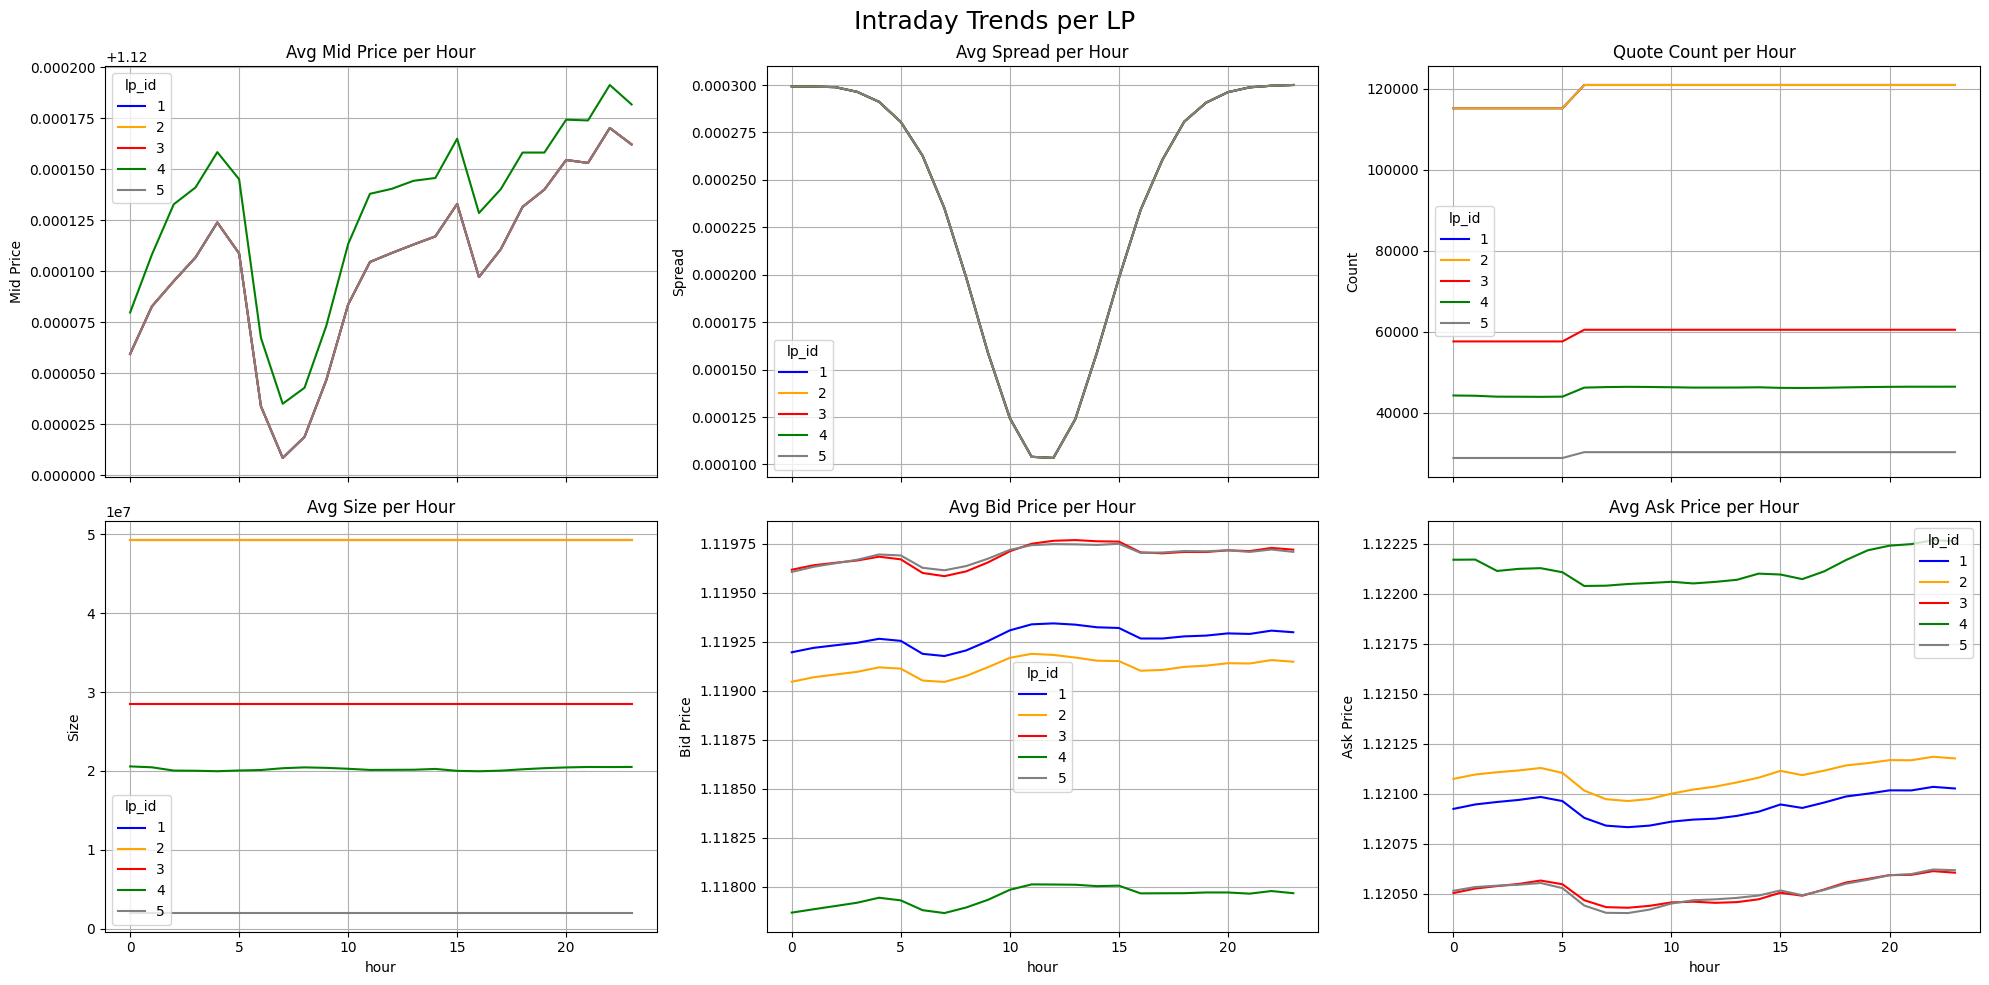

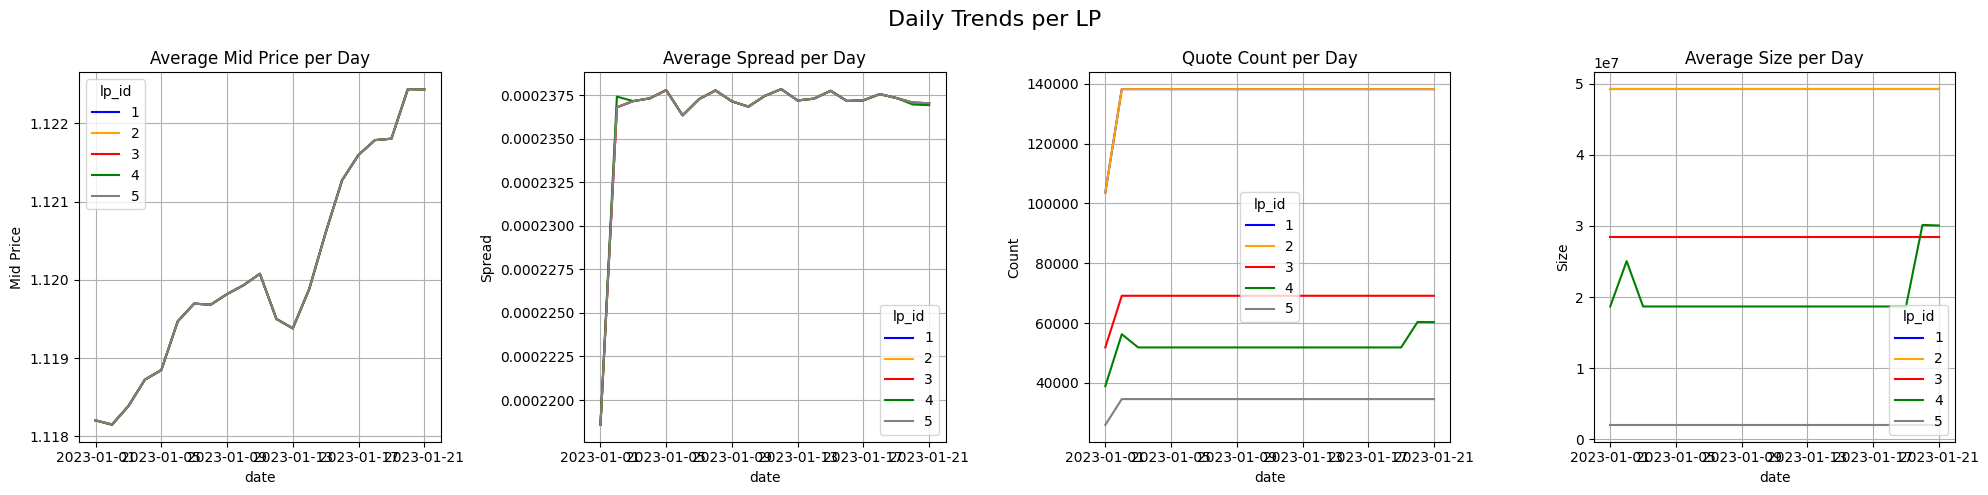

<ipython-input-62-9a6f277a8377>:112: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['lp_id', 'date', 'liquidity_level']).size().reset_index(name='quote_count')
<ipython-input-62-9a6f277a8377>:114: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = counts.pivot_table(


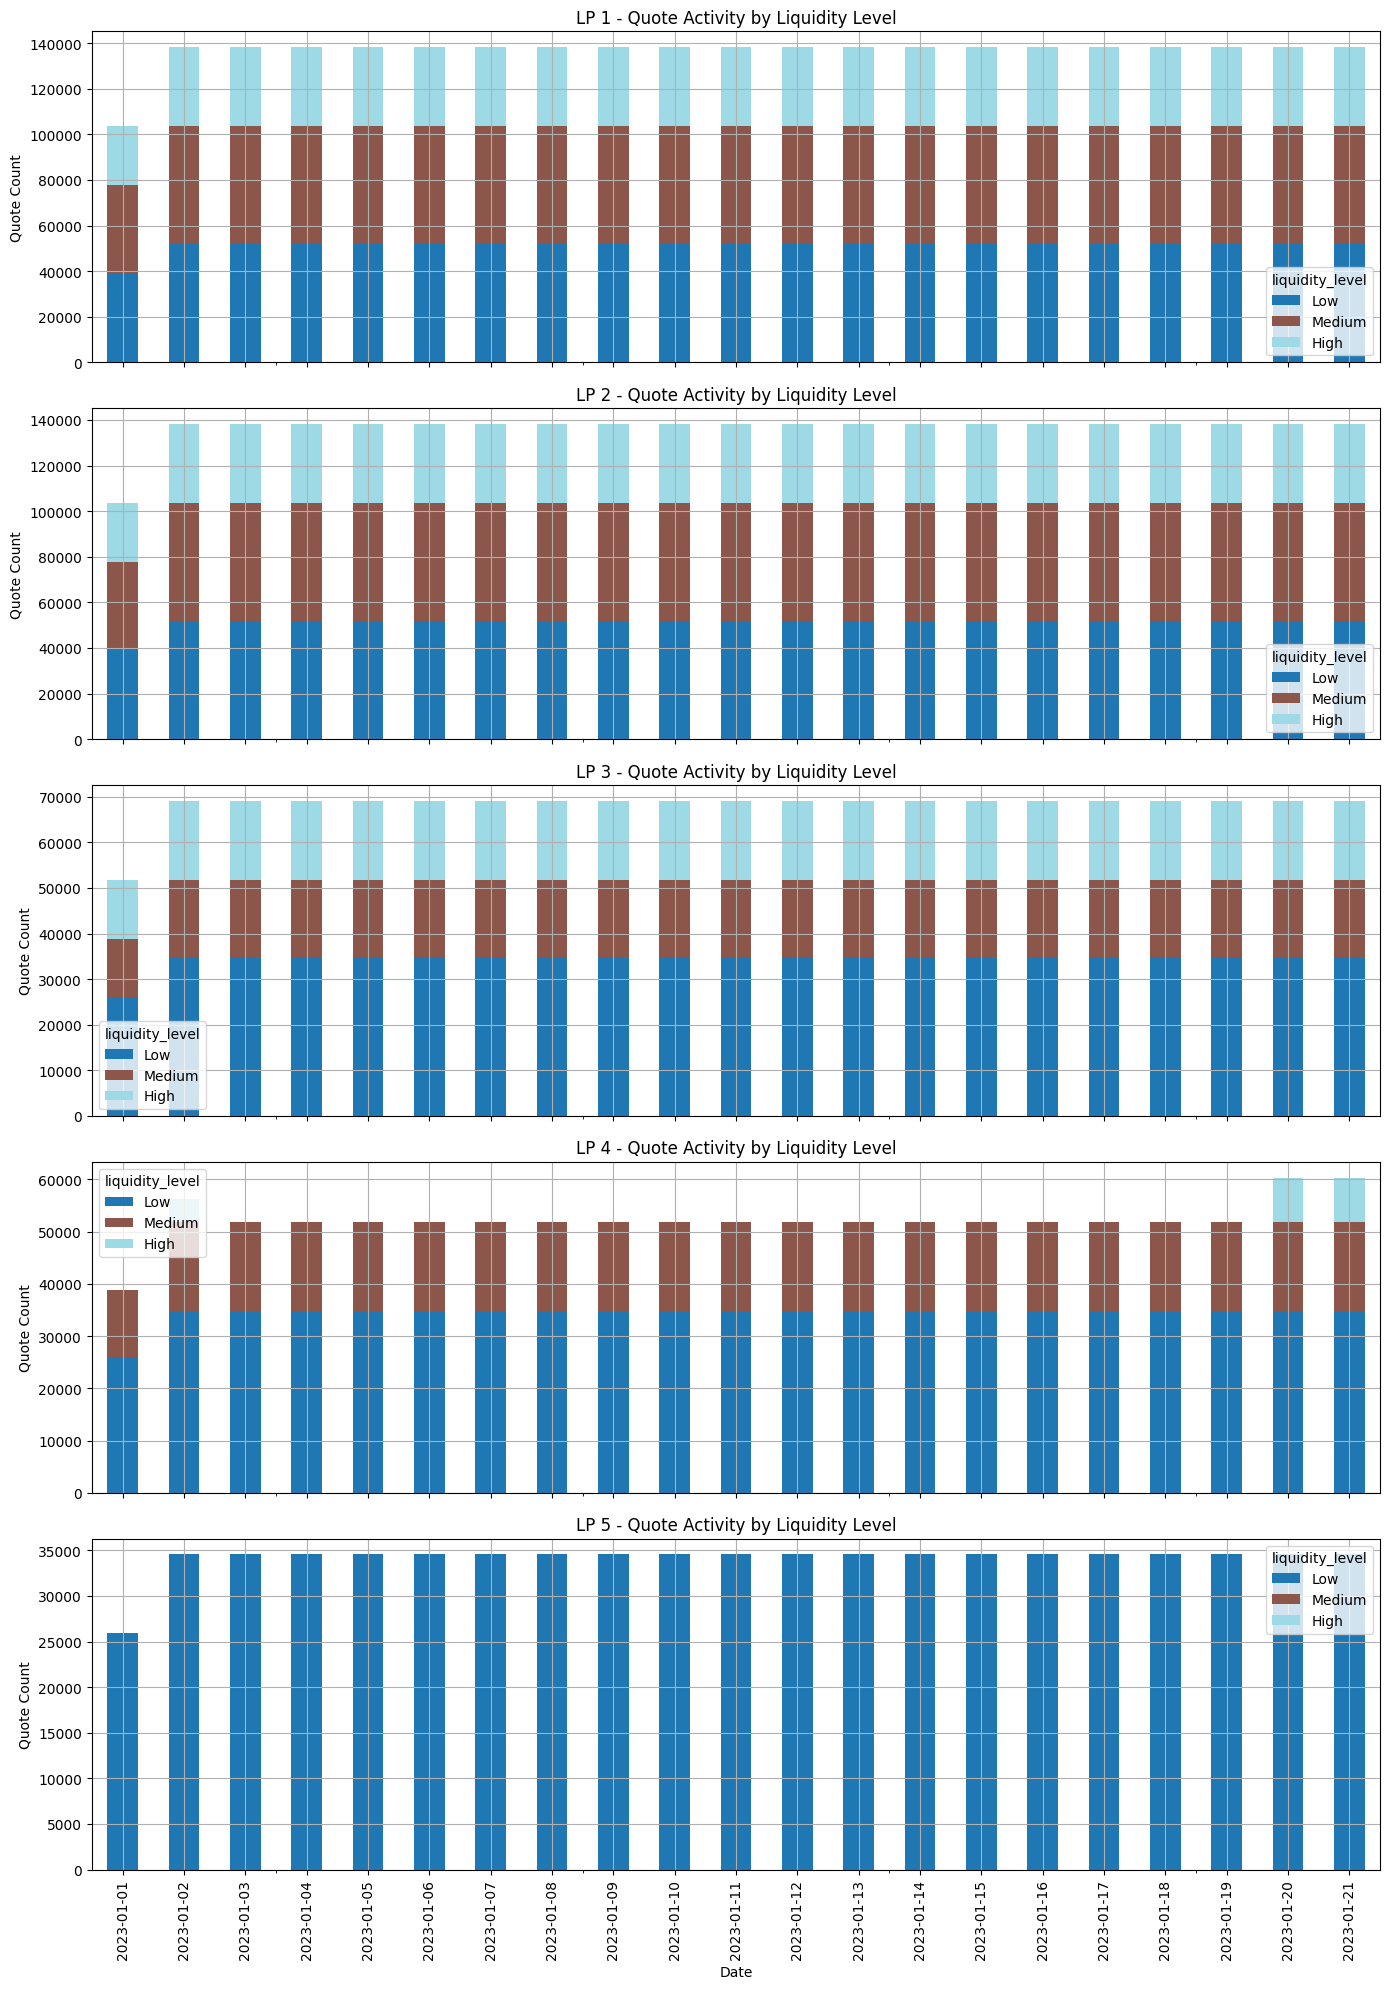

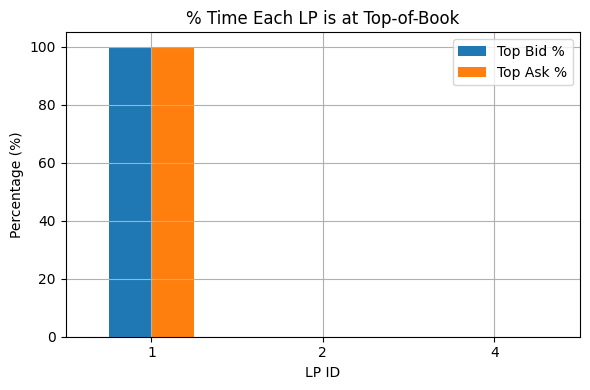

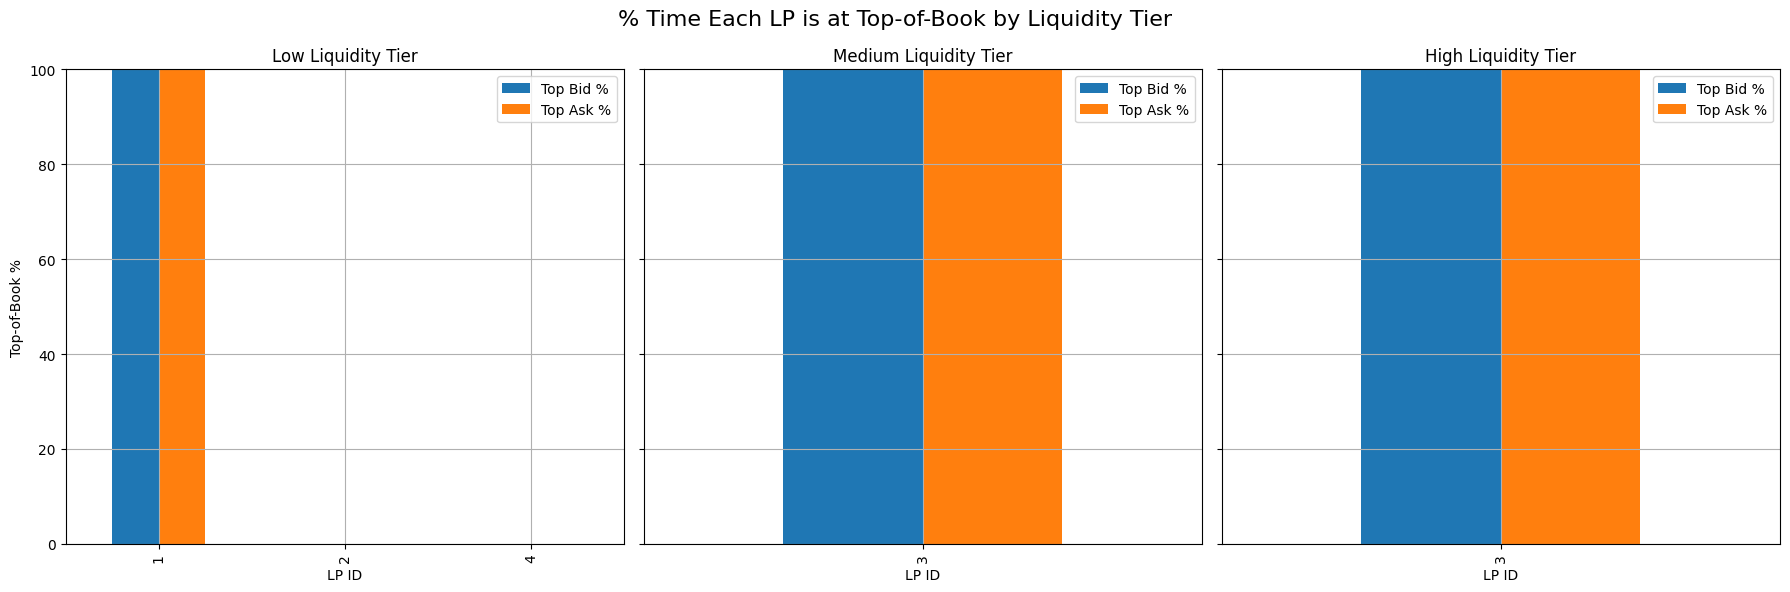

In [62]:
def analyze_intraday_trends_per_lp(df, palette):
    """ Derive intraday trends visualization for invidivual LPs"""
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour

    stats_mid = df.groupby(['lp_id', 'hour'])['mid_price'].mean().reset_index(name='avg_mid_price')
    stats_spread = df.groupby(['lp_id', 'hour'])['spread'].mean().reset_index(name='avg_spread')
    quote_counts = df.groupby(['lp_id', 'hour']).size().reset_index(name='quote_count')
    avg_sizes = df.groupby(['lp_id', 'hour'])['size'].mean().reset_index(name='avg_size')

    bid_prices = df[df['side'] == 'bid'].groupby(['lp_id', 'hour'])['price'].mean().reset_index(name='avg_bid_price')
    ask_prices = df[df['side'] == 'ask'].groupby(['lp_id', 'hour'])['price'].mean().reset_index(name='avg_ask_price')

    fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharex=True)

    sns.lineplot(data=stats_mid, x='hour', y='avg_mid_price', hue='lp_id', ax=ax[0, 0], palette=palette)
    ax[0, 0].set_title('Avg Mid Price per Hour')
    ax[0, 0].set_ylabel('Mid Price')
    ax[0, 0].grid(True)

    sns.lineplot(data=stats_spread, x='hour', y='avg_spread', hue='lp_id', ax=ax[0, 1], palette=palette)
    ax[0, 1].set_title('Avg Spread per Hour')
    ax[0, 1].set_ylabel('Spread')
    ax[0, 1].grid(True)

    sns.lineplot(data=quote_counts, x='hour', y='quote_count', hue='lp_id', ax=ax[0, 2], palette=palette)
    ax[0, 2].set_title('Quote Count per Hour')
    ax[0, 2].set_ylabel('Count')
    ax[0, 2].grid(True)

    sns.lineplot(data=avg_sizes, x='hour', y='avg_size', hue='lp_id', ax=ax[1, 0], palette=palette)
    ax[1, 0].set_title('Avg Size per Hour')
    ax[1, 0].set_ylabel('Size')
    ax[1, 0].grid(True)

    sns.lineplot(data=bid_prices, x='hour', y='avg_bid_price', hue='lp_id', ax=ax[1, 1], palette=palette)
    ax[1, 1].set_title('Avg Bid Price per Hour')
    ax[1, 1].set_ylabel('Bid Price')
    ax[1, 1].grid(True)

    sns.lineplot(data=ask_prices, x='hour', y='avg_ask_price', hue='lp_id', ax=ax[1, 2], palette=palette)
    ax[1, 2].set_title('Avg Ask Price per Hour')
    ax[1, 2].set_ylabel('Ask Price')
    ax[1, 2].grid(True)

    fig.suptitle('Intraday Trends per LP', fontsize=18)
    plt.tight_layout()
    plt.show()


def analyze_daily_trends_per_lp(df, palette):
    """ Derive daily trends visualization for invidivual LPs."""
    df = df.copy()
    df['date'] = pd.to_datetime(df['timestamp']).dt.date

    daily_mid = df.groupby(['lp_id', 'date'])['mid_price'].mean().reset_index(name='avg_mid_price')
    daily_spread = df.groupby(['lp_id', 'date'])['spread'].mean().reset_index(name='avg_spread')
    quote_counts = df.groupby(['lp_id', 'date']).size().reset_index(name='quote_count')
    daily_sizes = df.groupby(['lp_id', 'date'])['size'].mean().reset_index(name='avg_size')

    fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True)

    sns.lineplot(data=daily_mid, x='date', y='avg_mid_price', hue='lp_id', ax=ax[0], palette=palette)
    ax[0].set_title('Average Mid Price per Day')
    ax[0].set_ylabel('Mid Price')
    ax[0].grid(True)

    # Daily Spread
    sns.lineplot(data=daily_spread, x='date', y='avg_spread', hue='lp_id', ax=ax[1], palette=palette)
    ax[1].set_title('Average Spread per Day')
    ax[1].set_ylabel('Spread')
    ax[1].grid(True)

    # Quote Count
    sns.lineplot(data=quote_counts, x='date', y='quote_count', hue='lp_id', ax=ax[2], palette=palette)
    ax[2].set_title('Quote Count per Day')
    ax[2].set_ylabel('Count')
    ax[2].grid(True)

    # Avg Size
    sns.lineplot(data=daily_sizes, x='date', y='avg_size', hue='lp_id', ax=ax[3], palette=palette)
    ax[3].set_title('Average Size per Day')
    ax[3].set_ylabel('Size')
    ax[3].grid(True)

    fig.suptitle('Daily Trends per LP', fontsize=16)
    plt.tight_layout()
    plt.show()

def classify_liquidity_levels(df):
    """ Helper function for categorizing liquidity levels."""
    df = df.copy()
    bins = [0, 9_000_000, 90_000_000, float('inf')] # I defined it manually (Liquidity levels (LL) < 9M: Low, 9<MLL<90M:Medium, LL>90M: High)
    size_bins = pd.cut(df['size'], bins=bins, labels=['Low', 'Medium', 'High'], right=False)
    df['liquidity_level'] = size_bins

    return df

def prepare_stacked_data(df):
    """ Helper function for stacking data for liquiidity levels visualizations per each LPs."""
    df = classify_liquidity_levels(df)
    df['date'] = pd.to_datetime(df['timestamp']).dt.date

    counts = df.groupby(['lp_id', 'date', 'liquidity_level']).size().reset_index(name='quote_count')

    pivot = counts.pivot_table(
        index=['lp_id', 'date'],
        columns='liquidity_level',
        values='quote_count',
        fill_value=0
    ).reset_index()

    return pivot

def plot_stacked_liquidity_activity(df):
    """ Helpfer function for visualizing LPs performance in different liquidity levels."""
    pivot = prepare_stacked_data(df)
    liquidity_levels = ['Low', 'Medium', 'High']

    lp_ids = pivot['lp_id'].unique()
    n_lps = len(lp_ids)

    fig, axes = plt.subplots(n_lps, 1, figsize=(14, 4 * n_lps), sharex=True)

    if n_lps == 1:
        axes = [axes]

    for i, lp in enumerate(lp_ids):
        df_lp = pivot[pivot['lp_id'] == lp].set_index('date')
        df_lp[liquidity_levels].plot(
            kind='bar',
            stacked=True,
            ax=axes[i],
            colormap='tab20'
        )
        axes[i].set_title(f'LP {lp} - Quote Activity by Liquidity Level')
        axes[i].set_ylabel('Quote Count')
        axes[i].grid(True)

    axes[-1].set_xlabel('Date')
    plt.tight_layout()
    plt.show()


def plot_lp_top_of_book_share(df):
    """ Helper function for visualizing top of book LPs."""
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    bid_df = df[df['side'] == 'bid']
    ask_df = df[df['side'] == 'ask']

    best_bids = bid_df.loc[bid_df.groupby('timestamp')['price'].idxmax()]
    best_asks = ask_df.loc[ask_df.groupby('timestamp')['price'].idxmin()]

    top_bid_counts = best_bids['lp_id'].value_counts()
    top_ask_counts = best_asks['lp_id'].value_counts()

    total_timestamps = df['timestamp'].nunique()

    top_df = pd.DataFrame({
        'Top Bid %': (top_bid_counts / total_timestamps * 100).round(2),
        'Top Ask %': (top_ask_counts / total_timestamps * 100).round(2)
    }).fillna(0).sort_index()

    ax = top_df.plot(kind='bar', figsize=(6, 4))
    ax.set_title('% Time Each LP is at Top-of-Book')
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel('LP ID')
    ax.grid(True)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


def plot_top_of_book_by_liquidity(df):
    """ Helper function for visualizing top of book LPs at different liquidity levels."""
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = classify_liquidity_levels(df)


    result = {}

    for level in ['Low', 'Medium', 'High']:
        tier_df = df[df['liquidity_level'] == level]

        bid_df = tier_df[tier_df['side'] == 'bid']
        ask_df = tier_df[tier_df['side'] == 'ask']

        best_bids = bid_df.loc[bid_df.groupby('timestamp')['price'].idxmax()]
        best_asks = ask_df.loc[ask_df.groupby('timestamp')['price'].idxmin()]

        bid_counts = best_bids['lp_id'].value_counts()
        ask_counts = best_asks['lp_id'].value_counts()

        total_ts = tier_df['timestamp'].nunique()

        result[level] = pd.DataFrame({
            'Top Bid %': (bid_counts / total_ts * 100).round(2),
            'Top Ask %': (ask_counts / total_ts * 100).round(2)
        }).fillna(0)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, level in enumerate(['Low', 'Medium', 'High']):
        result[level].sort_index().plot.bar(
            ax=axes[i],
            title=f'{level} Liquidity Tier',
            ylabel='Top-of-Book %',
            xlabel='LP ID'
        )
        axes[i].grid(True)
        axes[i].set_ylim(0, 100)

    fig.suptitle('% Time Each LP is at Top-of-Book by Liquidity Tier', fontsize=16)
    plt.tight_layout()
    plt.show()

def run_analytics_lp(df, palette):
    """ Main function for visualyzing invidual trends across each LPs.
        Parameters:
        - df: preprocessed lp quoutes DataFrame.
        - palette: list of colors for each LP.
    """
    df = prepare_time_feature(df)
    mid_price_dd = mid_price_compute(df)
    spread = spread_compute(df)
    df = df.merge(mid_price_dd, on='timestamp', how='left').merge(spread, on='timestamp', how='left')
    analyze_intraday_trends_per_lp(df, palette)
    analyze_daily_trends_per_lp(df, palette)
    plot_stacked_liquidity_activity(df)
    plot_lp_top_of_book_share(df)
    plot_top_of_book_by_liquidity(df)

palette = ['blue', 'orange', 'red', 'green', 'gray']
print("Comparing LPs intraday...")
run_analytics_lp(df_preprocessed, palette)

**Insights**

Intraday Behaviors

The average prices offered by LP_ID=4 is slightly higher than others regardless of day time, while all LPs show almost same Spread. Additionally, LP_ID=1,2 shows significant higher activation in btoh number of quotes and quotes liquidity levels. The LP_ID=3 is moderately active while other LPs represent lower activation and liquidiy levels.

Interday Behavior

The patterns and trends are similiar to previous explanations.

Activity in Various Liquidiy Levels

LP_ID=5 is always active in low liquidity levels (< 10M), LP_ID=4 shows the same with slight acitivty in Medium levels at the earlier and later phase of market activity, LP_ID=1 and 2 are almost in all of levels and days of market activity. Activity pattern of LP_ID=3 regarding participating in various levels is similar to LP_ID=1 and 2 however with lower amount of activity.

LP_ID=1 shows the highest performance for offering best bid and ask prices.

COnsidering deeper analysis about performance of LPs in offering best bid and ask prices at different liquidity levels, in low levels, LP_ID=1 is best and in moderate and higher levels, LP_ID=3 is the leader. This indicates LPs show different peformance levels at different liquidity levels.

#**Strategy Design**

In this section, I build my own quotes model. Among different strategies such as TOB quoting, SOR, VWAP, etc. I selected VWAP because it aggregates multiple levels fromm LPs and quotes at VWAP for a target size. Additionally, it can adjust spread based on liquidity depth. So, I found this model would be a potential good model for this challenge.

**Strategy1: Building VWAP Model for all levels**

In [11]:
def compute_vwap(prices, sizes, target_liq, top_price=None, max_price_diff=0.002, min_size=1e6, size_cap=5e6):
    """ Compute the VWAP for a given liquidity level.
        parameters:
          - prices: price values
          - sizes: liquidity level
          - target_liq: target liquidity level
        output:
          - VWAP value = sum(price * size) / sum(size)
    """
    cum_size = 0
    vwap_sum = 0
    size_cap = min(size_cap, target_liq)
    for p, s in zip(prices, sizes):
        if s < min_size:
            continue
        if top_price is not None and abs(p - top_price) > max_price_diff:
            continue
        take_size = min(s, target_liq - cum_size, size_cap)
        vwap_sum += p * take_size
        cum_size += take_size

        if cum_size >= target_liq:
            break

    return vwap_sum / target_liq if cum_size > 0 else np.nan

def compute_vwap_for_order_book(order_book, liquidty_levels):
    """ Compute the VWAP for each liquidity level in the order book.
        Parameters:
          - order_book: consoldiated order book (Pandas DataFrame)
          - liqudity levels: list of liquidity levels
        Output:
          - DataFrame with VWAP for each liquidity level and bid and ask prices. columns=['timestamp', 'liquidity_level', 'vwap_bid', 'vwap_ask', 'mid_price', 'spread']
    """

    liq_thresholds = [lql * 1000000 for lql in liquidty_levels]
    results = []

    for _, row in order_book.iterrows():
        ts = row['timestamp']
        bid_prices = row['bid_prices']
        bid_sizes = row['bid_sizes']
        ask_prices = row['ask_prices']
        ask_sizes = row['ask_sizes']

        if bid_prices and bid_sizes:
            bids = sorted(zip(bid_prices, bid_sizes), key=lambda x: -x[0]) # Descending order for bids
            sorted_bid_prices, sorted_bid_sizes = zip(*bids)
        else:
            sorted_bid_prices, sorted_bid_sizes = [], []
        if ask_prices and ask_sizes:
            asks = sorted(zip(ask_prices, ask_sizes), key=lambda x: x[0])
            sorted_ask_prices, sorted_ask_sizes = zip(*asks) # Ascending order for asks
        else:
            sorted_ask_prices, sorted_ask_sizes = [], []

        best_bid = sorted_bid_prices[0] if sorted_bid_prices else None
        best_ask = sorted_ask_prices[0] if sorted_ask_prices else None

        for liq, liq_target in zip(liquidty_levels, liq_thresholds):
            vwap_bid = compute_vwap(sorted_bid_prices, sorted_bid_sizes, liq_target, top_price=best_bid)
            vwap_ask = compute_vwap(sorted_ask_prices, sorted_ask_sizes, liq_target, top_price=best_ask)
            mid = (vwap_bid + vwap_ask) / 2 if pd.notna(vwap_bid) and pd.notna(vwap_ask) and vwap_ask > vwap_bid else np.nan
            spread = (vwap_ask - vwap_bid) if pd.notna(vwap_bid) and pd.notna(vwap_ask) and vwap_ask > vwap_bid else np.nan

            results.append({
                'timestamp': ts,
                'liquidity_level': liq,
                'vwap_bid': vwap_bid,
                'vwap_ask': vwap_ask,
                'mid_price': mid,
                'spread': spread
            })

    return pd.DataFrame(results)


**Strategy2: Build Hybrid Model (VWAP for low liquidity levels and Machine Learning model for low and high levels)**

In [12]:
# Create Feature engineering dataset
def engineer_features_with_history(df, lp_score_dict):
    """ Function for creating features for machine learning model.
    Parameters:
      - df: prepocessed quotes dataframe.
      - lp_score_dict: dictionary of LP scores.
    Output:
      - DataFrame with engineered features.
    """
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Only sizes ≥ 10M
    high_sizes = [10_000_000, 50_000_000, 75_000_000, 100_000_000, 150_000_000]
    df = df[df["size"].isin(high_sizes)]

    # Map LP scores and add time info
    df["lp_score"] = df["lp_id"].map(lp_score_dict)
    df["hour"] = df["timestamp"].dt.hour
    df["day_of_week"] = df["timestamp"].dt.dayofweek

    # Use latest quote per LP per (timestamp, side, size)
    df.sort_values("timestamp", inplace=True)
    df = df.groupby(['timestamp', 'side', 'size', 'lp_id'], as_index=False).last()

    # Calculate mid and spread
    mid_df = df.pivot_table(index='timestamp', columns='side', values='price', aggfunc='mean')
    mid_df['bid'] = mid_df.get('bid')
    mid_df['ask'] = mid_df.get('ask')
    mid_df['mid_price'] = mid_df[['bid', 'ask']].mean(axis=1)
    mid_df['spread'] = (mid_df['ask'] - mid_df['bid']).abs()
    df = df.merge(mid_df[['mid_price', 'spread']], on='timestamp', how='left')

    # Add price-weighted field
    df["price_x_score"] = df["price"] * df["lp_score"]

    # Size-related features
    df["timestamp_rounded"] = df["timestamp"].dt.floor("1min")

    group_stats = df.groupby(["timestamp_rounded", "side"])["size"].agg(["mean", "max", "std"]).reset_index()
    group_stats.columns = ["timestamp_rounded", "side", "size_mean", "size_max", "size_std"]
    df = df.merge(group_stats, on=["timestamp_rounded", "side"], how="left")


    df["log_size"] = np.log1p(df["size"])
    df["relative_size_to_mean"] = df["size"] / df["size_mean"]
    df["relative_size_to_max"] = df["size"] / df["size_max"]
    df["size_zscore"] = (df["size"] - df["size_mean"]) / df["size_std"]
    df["size_x_mid"] = df["size"] * df["mid_price"]
    df["size_x_spread"] = df["size"] * df["spread"]
    df["size_x_lp_score"] = df["size"] * df["lp_score"]
    df["size_bucket"] = pd.cut(df["size"], bins=[0, 10_000_000, 50_000_000, 100_000_000, 150_000_000],
                                labels=["small", "mid", "large", "xlarge"])
    df = pd.get_dummies(df, columns=["size_bucket"], drop_first=True)

    # Extended aggregation
    agg = df.groupby(['timestamp', 'side', 'size']).agg(
        price_mean=('price', 'mean'),
        price_std=('price', 'std'),
        price_min=('price', 'min'),
        price_max=('price', 'max'),
        lp_score_mean=('lp_score', 'mean'),
        lp_score_std=('lp_score', 'std'),
        lp_count=('lp_score', 'count'),
        sum_price_x_score=('price_x_score', 'sum'),
        sum_lp_score=('lp_score', 'sum'),
        size_total=('size', 'sum'),
        size_std=('size', 'std'),
        hour=('hour', 'first'),
        day_of_week=('day_of_week', 'first'),
        mid_price=('mid_price', 'first'),
        spread=('spread', 'first'),
        log_size=('log_size', 'first'),
        relative_size_to_mean=('relative_size_to_mean', 'first'),
        relative_size_to_max=('relative_size_to_max', 'first'),
        size_zscore=('size_zscore', 'first'),
        size_x_mid=('size_x_mid', 'first'),
        size_x_spread=('size_x_spread', 'first'),
        size_x_lp_score=('size_x_lp_score', 'first'),
    ).reset_index()

    # Weighted price
    agg["weighted_price"] = agg["sum_price_x_score"] / agg["sum_lp_score"]
    agg.drop(columns=["sum_price_x_score", "sum_lp_score"], inplace=True)
    # price range
    agg["price_range"] = agg["price_max"] - agg["price_min"]

    # LP quote dispersion
    lp_dist = df.copy()
    lp_dist["abs_dev_from_mid"] = (lp_dist["price"] - lp_dist["mid_price"]).abs()
    quote_deviation = lp_dist.groupby(['timestamp', 'side', 'size'])["abs_dev_from_mid"].mean().reset_index()
    agg = agg.merge(quote_deviation, on=["timestamp", "side", "size"], how="left")
    agg.rename(columns={"abs_dev_from_mid": "lp_price_deviation_mean"}, inplace=True)

    # Quote entropy
    from scipy.stats import entropy
    def calc_entropy(scores):
        norm = scores / scores.sum() if scores.sum() > 0 else scores
        return entropy(norm)

    #quote_entropy = df.groupby(['timestamp', 'side', 'size'])['lp_score'].apply(calc_entropy).reset_index(name='score_entropy')
    #agg = agg.merge(quote_entropy, on=["timestamp", "side", "size"], how="left") # I think ENtropy could be also a good metric, however its computation was time-consuming, so i ignore it, now.

    # Rolling & lag features
    agg["rolling_price_mean_30"] = np.nan
    agg["rolling_price_std_30"] = np.nan
    agg["rolling_lp_count_30"] = np.nan
    agg["momentum_lag_180"] = np.nan

    def add_rolling_features(group):
        group = group.sort_values("timestamp").copy()

        if len(group) >= 180:
            group["rolling_price_mean_30"] = group["price_mean"].rolling(30, min_periods=5).mean()
            group["rolling_price_std_30"] = group["price_mean"].rolling(30, min_periods=5).std()
            group["rolling_lp_count_30"] = group["lp_count"].rolling(30, min_periods=5).mean()
            group["momentum_lag_180"] = group["price_mean"] - group["price_mean"].shift(180)
            group["rolling_spread_std_30"] = group["spread"].rolling(30, min_periods=5).std()
            group["rolling_price_vol_30"] = group["price_mean"].rolling(30, min_periods=5).std()
        return group

    agg = agg.groupby(['side', 'size'], group_keys=False).apply(add_rolling_features)

    agg.dropna(subset=["rolling_price_mean_30", "momentum_lag_180"], inplace=True)
    agg["hour"] = np.sin(2 * np.pi * df["hour"] / 24)
    agg["day_of_week"] = np.sin(2 * np.pi * agg["day_of_week"] / 7)

    return agg

lp_score = {1: 0.91, 2: 0.8, 3: 0.65, 4: 0.17, 5: 0.35}
features = engineer_features_with_history(df_preprocessed, lp_score)
#features.dropna(inplace=True)

<ipython-input-12-0dc152d18f73>:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(['timestamp', 'side', 'size', 'lp_id'], as_index=False).last()
<ipython-input-12-0dc152d18f73>:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  mid_df = df.pivot_table(index='timestamp', columns='side', values='price', aggfunc='mean')
<ipython-input-12-0dc152d18f73>:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df.groupby(["timestamp

In [13]:
features.drop(columns=["price_max", "price_min", "price_range", "weighted_price"], inplace=True, errors="ignore")
# Relative price to market context
features["rel_price_to_mid"] = features["price_mean"] - features["mid_price"]

# Price z-score: how far is price_mean from its recent trend
features["price_zscore"] = (features["price_mean"] - features["rolling_price_mean_30"]) / features["rolling_price_std_30"]

**Features Correlation Visualization**

This step is done to investigate potential corrleation between extracted features and removing them to prevent from colinearity effect in training.

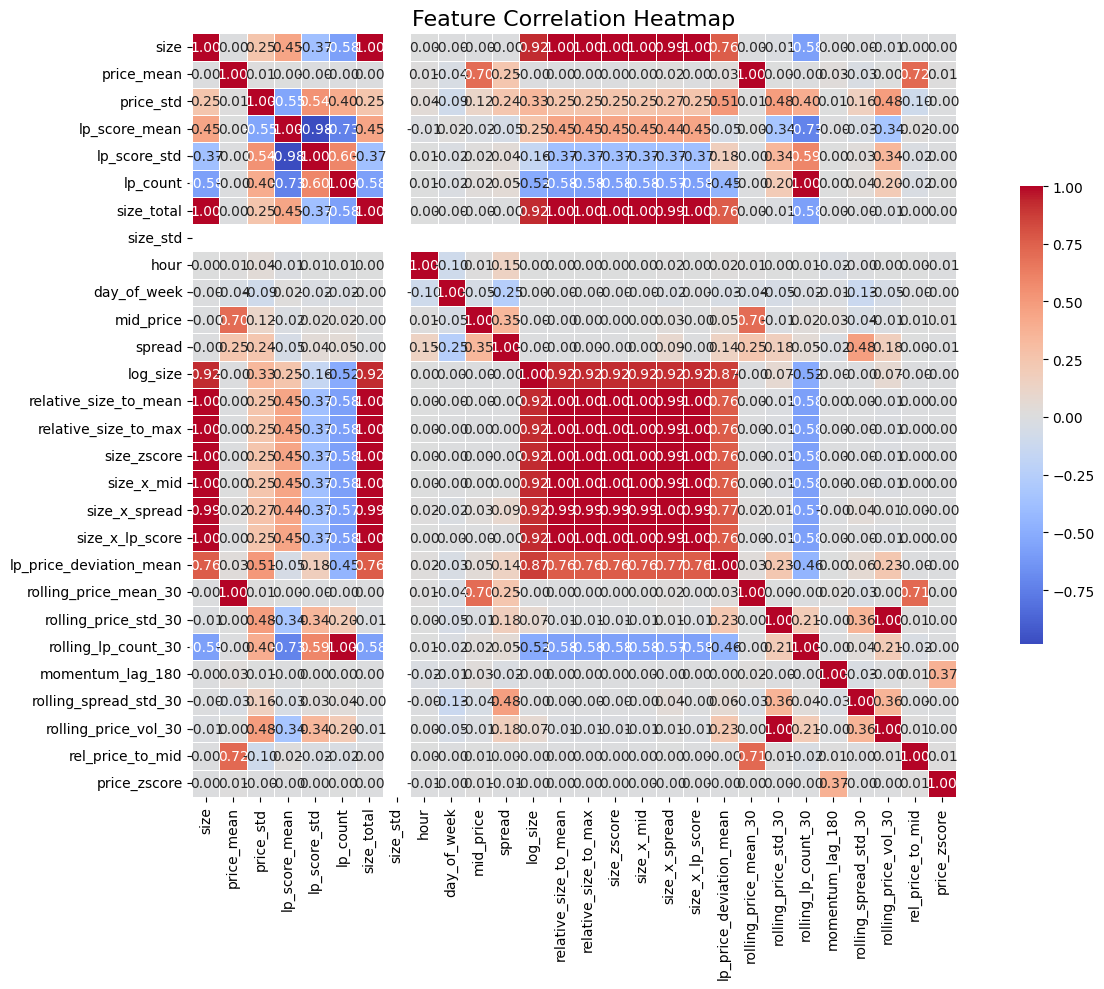

In [32]:
numeric_features = features.select_dtypes(include=["number"])
plt.figure(figsize=(14, 10))
corr = numeric_features.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={'shrink': 0.6}, linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
features.drop(columns=["price_max", "price_min", "price_range", "weighted_price"], inplace=True, errors="ignore") # remove linear-correlated columns

**Creating Labels**

In [45]:
def create_labels(df, lp_score_dict, top_n_lp=2):
    """ Function for creating labels for feature datasets.
        Parameters:
          - df: prepocessed quotes dataframe.
          - lp_score_dict: dictionary of LP scores.
          - top_n_lp: number of top LPs to consider.
        Output:
          - DataFrame with labels.
    """
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df[df["size"].isin([10000000, 50000000, 75000000, 100000000, 150000000])]
    df["lp_score"] = df["lp_id"].map(lp_score_dict)

    # Keep latest quote per LP
    df.sort_values(by="timestamp", inplace=True)
    df = df.groupby(["timestamp", "side", "size", "lp_id"], as_index=False).last()

    # Rank LPs within each group by score
    df["lp_rank"] = df.groupby(["timestamp", "side", "size"])["lp_score"] \
                      .rank(method="first", ascending=False)

    # Keep top N LPs only
    df_top = df[df["lp_rank"] <= top_n_lp]

    # Compute competitive price: min for ask, max for bid
    ask_prices = (
        df_top[df_top["side"] == "ask"]
        .groupby(["timestamp", "side", "size"], as_index=False)["price"]
        .min()
        .rename(columns={"price": "target_price"})
    )

    bid_prices = (
        df_top[df_top["side"] == "bid"]
        .groupby(["timestamp", "side", "size"], as_index=False)["price"]
        .max()
        .rename(columns={"price": "target_price"})
    )

    label_df = pd.concat([ask_prices, bid_prices], axis=0).reset_index(drop=True)

    return label_df


labels = create_labels(df_preprocessed, lp_score, top_n_lp=2)


<ipython-input-45-718297b908a1>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(["timestamp", "side", "size", "lp_id"], as_index=False).last()
<ipython-input-45-718297b908a1>:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["timestamp", "side", "size"], as_index=False)["price"]


In [46]:
labels.head()

,timestamp,side,size,target_price
0,2023-01-01 06:00:00,ask,10000000,1.118992
1,2023-01-01 06:00:00,ask,50000000,1.119446
2,2023-01-01 06:00:00,ask,75000000,1.119569
3,2023-01-01 06:00:00,ask,100000000,1.119670
4,2023-01-01 06:00:00,ask,150000000,1.119766


**Merge features with labels to create training dataset**

In [47]:
def merge_feature_label(features, labels):
  """ Helpfer function for merging features dataframe with labels"""
  training_df = features.merge(labels, on=["timestamp", "side", "size"], how="inner") # merge feature dataset with labels
  training_df = training_df.sort_values("timestamp").reset_index(drop=True)
  training_df = training_df.dropna()
  return training_df

training_df = merge_feature_label(features, labels)

In [89]:
training_df.head()

,timestamp,side,size,price_mean,price_std,lp_score_mean,lp_score_std,lp_count,size_total,size_std,...,lp_price_deviation_mean,rolling_price_mean_30,rolling_price_std_30,rolling_lp_count_30,momentum_lag_180,rolling_spread_std_30,rolling_price_vol_30,rel_price_to_mid,price_zscore,target_price
0,2023-01-01 06:30:00,ask,10000000,1.118849,0.000182,0.786667,0.130512,3,40000000,0.0,...,0.000534,1.118854,0.000020,3.0,-0.000082,0.000009,0.000020,0.000534,-0.256568,1.118909
1,2023-01-01 06:30:00,bid,150000000,1.116650,0.000411,0.855000,0.077782,2,600000000,0.0,...,0.001665,1.116634,0.000017,2.0,-0.000015,0.000009,0.000017,-0.001665,0.952353,1.116941
3,2023-01-01 06:30:00,bid,100000000,1.117129,0.000470,0.786667,0.130512,3,400000000,0.0,...,0.001186,1.117110,0.000019,3.0,0.000003,0.000009,0.000019,-0.001186,0.989795,1.117030
5,2023-01-01 06:30:00,bid,75000000,1.116977,0.000143,0.855000,0.077782,2,300000000,0.0,...,0.001338,1.116985,0.000019,2.0,-0.000071,0.000009,0.000019,-0.001338,-0.412753,1.117078
8,2023-01-01 06:30:00,bid,10000000,1.117772,0.000154,0.786667,0.130512,3,40000000,0.0,...,0.000543,1.117750,0.000021,3.0,-0.000009,0.000009,0.000021,-0.000543,1.025867,1.117787


**Train-Test Splitting**

Approach for splitting train-test dataset: Dataset is time series. While one way is so split train-split using random row-wise splitting, There price values is non-stationary and shows an icnreasing trend over days of trainig, So, using first approach might no very appropriate. Alterntative approach is splitting dataset based on daily appraoch which might be able to capture trends and patterns in real-world. So, I decided to split dataset for training (in-sample) and testing (out-of-sample) by selecting days. 3 days were selected for testing and remaining for training.

In [75]:
def day_based_split(df, date_col="timestamp", valid_days=3, test_days=2):
    """ splits the dataframe into train, validation, and test sets based on daily order.
        Parameters:
          - df: DataFrame containing time-based data
          - date_col: Column with datetime values
          - valid_day: Number of days for validation set
          - test_days: Number of days for final holdout set
        Output:
          train_df, valid_df, test_df
    """
    df = df.copy()
    df["date"] = pd.to_datetime(df[date_col]).dt.date
    unique_dates = sorted(df["date"].unique())

    # Defensive check
    if valid_days + test_days >= len(unique_dates):
        raise ValueError("Not enough data to split into train, validation, and test sets.")

    train_days = unique_dates[:-(valid_days + test_days)]
    valid_days = unique_dates[-(valid_days + test_days):-test_days]
    test_days  = unique_dates[-test_days:]

    train_df = df[df["date"].isin(train_days)].copy()
    valid_df = df[df["date"].isin(valid_days)].copy()
    test_df  = df[df["date"].isin(test_days)].copy()

    return train_df, valid_df, test_df


def add_normalized_price_features(df):
    df = df.copy()
    df["normalized_price"] = df["my_bid"] / df["mid_price"]
    df["normalized_spread"] = df["spread"] / df["mid_price"]
    return df


**Training Pipeline**

As the dataset samples are imbalanced and different liquidity levels, I selected Light Gradient Boosting Regressor Model which is good for handling imbalanced challenges and also light-weight for running which is also useful and helpful in real-world eFX that is high-frquent trading and needs giving rapid insights about the market.

In [90]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

def run_bid_ask_model(training_df, target_col="target_price", test_days=3):
    """ Function for building training ML model.
        Parameters:
          - training_df: raw training dataframe
          - target_col: label column definition (str)
          - test_days: Number of days for creating training and test datasets using daily approach.
        Output:
          - Dictionary of model results. {model, X_train, X_test, y_train, y_test, MAE, RMSE}
    """

    results = {}
    training_df = training_df.copy()
    training_df["date"] = pd.to_datetime(training_df["timestamp"]).dt.date

    #unique_dates = sorted(training_df["date"].unique())
    #train_days = unique_dates[:-test_days]
    #test_days = unique_dates[-test_days:]

    features_train, features_val, features_test = day_based_split(training_df, date_col="timestamp", valid_days=3, test_days=2)

    #features_train = training_df[training_df["date"].isin(train_days)].copy()
    #features_test  = training_df[training_df["date"].isin(test_days)].copy()

    for side in ["bid", "ask"]:
        df_train = features_train[features_train["side"] == side]
        df_val = features_val[features_val["side"] == side]
        df_test = features_test[features_test["side"] == side]

        y_train = df_train[target_col]
        y_val = df_val[target_col]
        y_test = df_test[target_col]

        drop_cols = ["timestamp", "side", "size", "date", target_col]
        X_train = df_train.drop(columns=[col for col in drop_cols if col in df_train.columns])
        X_val = df_val.drop(columns=[col for col in drop_cols if col in df_val.columns])
        X_test = df_test.drop(columns=[col for col in drop_cols if col in df_test.columns])


        model = LGBMRegressor(n_estimators=200, learning_rate=0.05, num_leaves=63, max_depth=7, random_state=42, verbosity=1, n_jobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae')
        y_pred = model.predict(X_val)

        mae = mean_absolute_error(y_val, y_pred)
        rmse = mean_squared_error(y_val, y_pred)

        results[side] = {
            "model": model,
            "X_train": X_train,
            "y_train": y_train,
            "X_val": X_val,
            "y_val": y_val,
            "X_test": X_test,
            "y_test": y_test,
            "y_pred": y_pred,
            "MAE": mae,
            "RMSE": rmse,
        }

    return results

results = run_bid_ask_model(training_df, target_col="target_price", test_days=3)
model_bid = results["bid"]["model"]
model_ask = results["ask"]["model"]



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3646
[LightGBM] [Info] Number of data points in the train set: 411716, number of used features: 26
[LightGBM] [Info] Start training from score 1.118382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.371410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3679
[LightGBM] [Info] Number of data points in the train set: 475158, number of used features: 26
[LightGBM] [Info] Start training from score 1.120655


In [91]:
print("VALIDATION MAE / RMSE:")
print("Bid:", results["bid"]["MAE"], "/", results["bid"]["RMSE"])
print("Ask:", results["ask"]["MAE"], "/", results["ask"]["RMSE"])

VALIDATION MAE / RMSE:
Bid: 0.00010788230140609677 / 2.5674183888577515e-08
Ask: 0.0001842553448726362 / 6.862190620761081e-08


In [98]:
# save model
import joblib
joblib.dump(model_bid, '/content/drive/My Drive/lgmboost_bid_model.pkl')
joblib.dump(model_ask, '/content/drive/My Drive/lgmboost_ask_model.pkl')


['/content/drive/My Drive/lgmboost_ask_model.pkl']

**Validation on unseen test data (not used during training and validaiton)**

In [93]:
def predict_price(model, side):
  y_pred = model.predict(results[side]["X_test"])
  return y_pred

def evaluate_model(model, side, y_pred, y_test):
  mae = mean_absolute_error(y_test, y_pred)
  rmse = mean_squared_error(y_test, y_pred)
  print(f"{side}: mae: {mae}, rmse: {rmse}")
  return mae, rmse

y_pred_bid = predict_price(model_bid, side='bid')
y_pred_ask = predict_price(model_ask, side='ask')

mae_bid, rmse_bid = evaluate_model(model_bid, side='bid', y_pred=y_pred_bid, y_test=results["bid"]["y_test"])
mae_ask, rmse_ask = evaluate_model(model_ask, side='ask', y_pred=y_pred_ask, y_test=results["ask"]["y_test"])


bid: mae: 0.0005290542132466987, rmse: 3.6266521236254905e-07
ask: mae: 0.0007795807179575749, rmse: 6.571552086226691e-07


Plt predicted vs True values

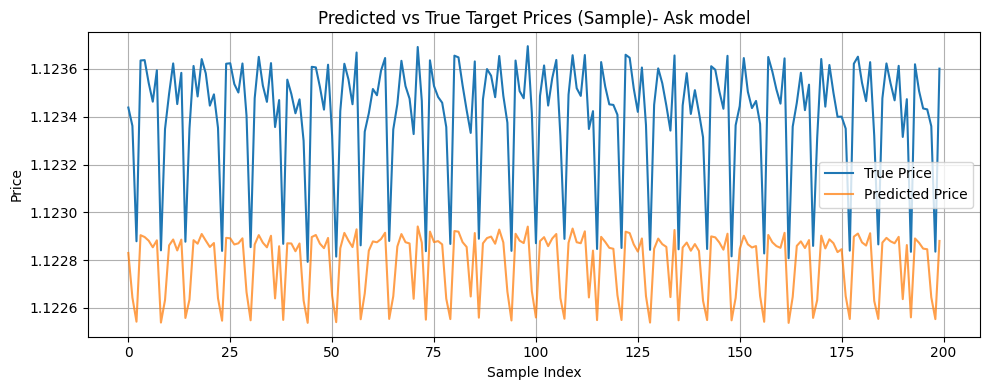

In [94]:
plt.figure(figsize=(10, 4))
plt.plot(results["ask"]["y_test"].values[:200], label="True Price")
plt.plot(y_pred_ask[:200], label="Predicted Price", alpha=0.75)
plt.title("Predicted vs True Target Prices (Sample)- Ask model")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


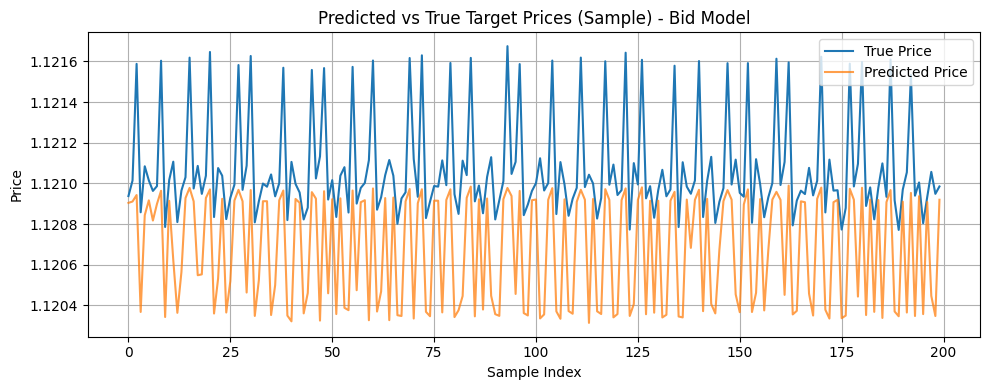

In [84]:
plt.figure(figsize=(10, 4))
plt.plot(results["bid"]["y_test"].values[:200], label="True Price")
plt.plot(y_pred_bid[:200], label="Predicted Price", alpha=0.75)
plt.title("Predicted vs True Target Prices (Sample) - Bid Model")
plt.xlabel("Sample Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Feature Importance**

<ipython-input-96-22548ce1cce9>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df.head(top_n), palette='viridis')


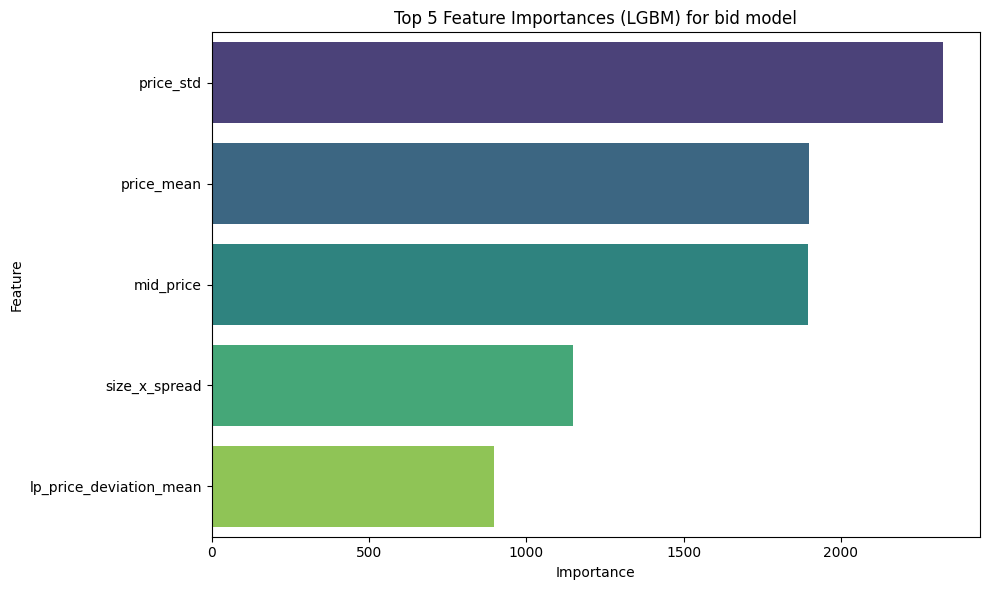

<ipython-input-96-22548ce1cce9>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df.head(top_n), palette='viridis')


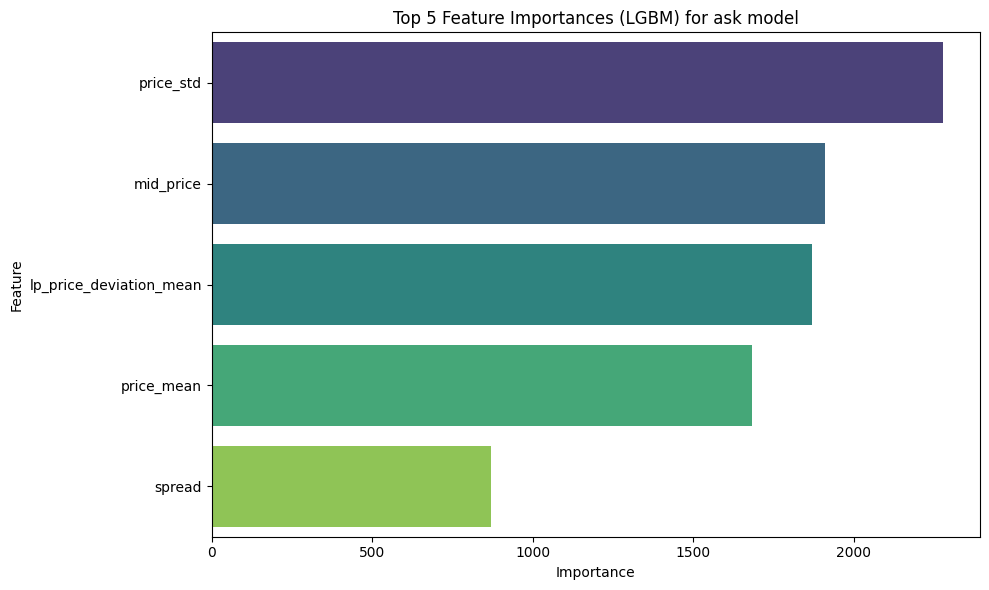

In [96]:
def plot_feature_importance(model, X, side, top_n=5):
    """ Function for visualizing feature importance o get insights about feature impacts on model decisions."""
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    })

    importance_df.sort_values(by='importance', ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df.head(top_n), palette='viridis')
    plt.title(f"Top {top_n} Feature Importances (LGBM) for {side} model")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_feature_importance(model_bid, results['bid']['X_train'], 'bid', top_n=5)
plot_feature_importance(model_ask, results['ask']['X_train'], 'ask', top_n=5)

**Inventory-Aware Quote Adjustment - Bonus**

In [158]:
def compute_inventory_over_time(trade_df):
    """
    Tracks cumulative internal inventory from trade_data.parquet
    """
    df = trade_df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Mark signed size: buy = +size, sell = -size (only for internal)
    df["signed_size"] = df.apply(
        lambda row: row["size"] if row["flag"] == "internal" and row["side"] == "buy"
        else -row["size"] if row["flag"] == "internal" and row["side"] == "sell"
        else 0,
        axis=1
    )

    df["inventory"] = df["signed_size"].cumsum()

    return df[["timestamp", "inventory"]]


def compute_market_pressure(trade_df, window="1min"):
    """
    Computes rolling external market pressure over time
    """
    df = trade_df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df[df["flag"] == "external"]

    df["signed_flow"] = df["size"] * df["side"].map({"buy": 1, "sell": -1})

    pressure_df = df.resample(window, on="timestamp")["signed_flow"].sum().reset_index()
    pressure_df.columns = ["timestamp", "net_pressure"]

    return pressure_df


def adjust_quotes(mid, spread, inventory, pressure, inventory_limit=10_000_000):
    """ Adjusts quotes based on inventory and market pressure."""
    inv_factor = (inventory or 0) / inventory_limit
    pressure_lean = (pressure or 0) * 0.00001  # sensitivity

    mid_adj = mid + pressure_lean - inv_factor * spread * 0.5
    spread_adj = spread * (1 + abs(inv_factor) * 0.5)

    bid = mid_adj - spread_adj / 2
    ask = mid_adj + spread_adj / 2

    return bid, ask, mid_adj, spread_adj

**Metrics Evaluation**

After building model, the effectiveness of the model is assessed using metrics defined in the task challenge document, including:
1.	Bid and Ask Crossing: Evaluate the frequency and magnitude of bid and ask prices crossing each other. This metric helps in understanding the liquidity and price stability in the market.
2.	Top of the Book Coverage: Measure the percentage of time the model's bid and ask prices are at the top of the order book. This indicates the competitiveness of the model in attracting trades.
3.	LP Ranking: Rank liquidity providers based on their quote quality, response time, and consistency. This helps in identifying the most reliable LPs for market-making.
4.	Continuous Size Interpolation: Assess the model's ability to interpolate sizes continuously between quoted levels. This ensures that the model can handle varying order sizes effectively.
5.	Spread Width Analysis: Analyze the width of the bid-ask spread over time. A narrower spread indicates better market efficiency and higher liquidity.
6.	Market Impact: Evaluate the impact of the model's quotes on the overall market. This includes assessing how the model's prices influence market movements and liquidity.
7.	Price Stability: Measure the stability of the model's bid and ask prices over time. This helps in understanding the robustness of the model in different market conditions.

In [17]:
def bid_ask_crosing(quotes_df):
    """ Helpfer function for computing bid-ask crossing in the quotes DataFrame """
    crossed = quotes_df[quotes_df['my_bid'] >= quotes_df['my_ask']]
    crossing_rate = len(crossed) / len(quotes_df)
    crossing_magnitude = (crossed['my_bid'] - crossed['my_ask']).mean()

    return crossing_rate, crossing_magnitude

def top_of_book_coverage(quotes_df, order_book):
    """ Helpfer function for computing top of book coverage in the quotes DataFrame """
    merged = quotes_df.merge(order_book[['timestamp', 'bid_prices', 'ask_prices']], on='timestamp', how='inner')
    merged['top_bid'] = merged['bid_prices'].apply(lambda bids: max(bids))
    merged['top_ask'] = merged['ask_prices'].apply(lambda asks: min(asks))
    merged['at_top_bid'] = merged['my_bid'] >= merged['top_bid']
    merged['at_top_ask'] = merged['my_ask'] <= merged['top_ask']

    return merged['at_top_bid'].mean(), merged['at_top_ask'].mean()

def lp_ranking(quotes_df, n_top=1):
    """ Rank liquidity providers based on the number of quotes """
    ranks = []
    for side in ['bid', 'ask']:
        side_col = f'{side}_prices'
        side_order = -1 if side == 'bid' else 1
    for _, row in quotes_df.iterrows():
        prices = row[side_col]
        if not prices: continue
        top_prices = sorted(prices)[:n_top]
        for i, price in enumerate(top_prices):
            ranks.append((row['timestamp'], side, i, price))
    rank_df = pd.DataFrame(ranks, columns=['timestamp', 'side', 'rank', 'price'])

    return rank_df.groupby(['side', 'rank'])['price'].mean().reset_index()

def evaluate_size_interpolation(model_bid, model_ask, training_df, timestamp, size_range=range(5, 151), step=1):
    """
    Plots predicted bid, ask, mid, and spread over a range of liquidity sizes for a single timestamp.
      paramters:
        - model_bid, model_ask: bid/ask LGBMRegressor models
        - training_df: Engineered features including the given timestamp
        - timestamp: timestamp to test interpolation
        - size_range: List or range of liquidity sizes
    """

    df = training_df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    target_row = training_df[
    (training_df["timestamp"] == pd.to_datetime(timestamp)) &
    (training_df["side"] == "bid")
    ].copy()

    if target_row.empty:
      print("No matching row found!")
      return

    target_row = target_row.iloc[[0]]
    if target_row.empty:
        print(f"No features found for timestamp {timestamp}")
        return

    features_list = []
    for size in size_range:
        row = target_row.copy()
        row["size"] = size
        features_list.append(row)

    batch = pd.concat(features_list, ignore_index=True)
    #drop_cols = ['timestamp', 'side', 'target_price', 'date']
    feature_names = model_bid.feature_name_
    input_X = batch[feature_names]

    pred_bid = model_bid.predict(input_X)
    pred_ask = model_ask.predict(input_X)
    mid = (pred_bid + pred_ask) / 2
    spread = pred_ask - pred_bid

    plt.figure(figsize=(12, 6))
    plt.plot(size_range, pred_bid, label="Predicted Bid", color="blue")
    #plt.plot(size_range, pred_ask, label="Predicted Ask", color="red")
    #plt.plot(size_range, mid, label="Predicted Mid", color="black", linestyle='--')
    #plt.plot(size_range, spread, label="Spread", color="purple", linestyle=':')
    plt.xlabel("Liquidity Size (M)")
    plt.ylabel("Price")
    plt.title(f"Size Interpolation — Quotes at {timestamp}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def spread_width_analysis(quotes_df):
    """ Analyze the spread width in the quotes DataFrame. """
    avg_spread = quotes_df['my_ask'].sub(quotes_df['my_bid']).mean()
    min_spread = quotes_df['my_ask'].sub(quotes_df['my_bid']).min()
    max_spread = quotes_df['my_ask'].sub(quotes_df['my_bid']).max()

    return avg_spread, min_spread, max_spread

def price_stability(quotes_df):
    """ Check for price stability in the quotes DataFrame """
    bid_vol = quotes_df['my_bid'].diff().abs().mean()
    ask_vol = quotes_df['my_ask'].diff().abs().mean()
    return bid_vol, ask_vol

def market_impact(quotes_df, max_latency_ms=1000):
    """ Check for market impact in the quotes DataFrame """
    #internal = trade_df[trade_df['flag'] == 'internal'].copy()
    #merged = pd.merge_asof(
    #    internal.sort_values('timestamp'),
    #    quotes_df.sort_values('timestamp'),
    #    on='timestamp',
    #    direction='backward',
    #    tolerance=pd.Timedelta(milliseconds=max_latency_ms)
    #)
    matched = quotes_df['liquidity_level'].notna()
    impact_rate = matched.mean()

    return impact_rate

def evaluate_metrics(quotes_df, order_book):
    """ Main functionto derive evaluation metrics for model performance.
        Parameters:
          - quotes_df: dataframe of generated quotes by model
          - order_book: consoldiated orderbook DataFrame
        Output:
          - DataFrame of evaluation metrics.
    """

    crossing_rate, crossing_magnitude = bid_ask_crosing(quotes_df)
    crossing_metrics = {"Crossing Rate": round(crossing_rate, 2), "Crossing Magnitude": round(crossing_magnitude, 6)}

    top_of_book_bid, top_of_book_ask = top_of_book_coverage(quotes_df, order_book)
    top_of_books_coverage_metrics = {"Top-of-Book Bid": round(top_of_book_bid, 2), "Top-of-Book Ask": round(top_of_book_ask, 6)}

    avg_spread, min_spread, max_spread = spread_width_analysis(quotes_df)
    spread_metrics = {"Average Spread": round(avg_spread, 6), "Minimum Spread": round(min_spread, 6), "Maximum Spread": round(max_spread, 6)}

    bid_vol, ask_vol = price_stability(quotes_df)
    price_stability_metrics = {"Bid Volatility": round(bid_vol, 6), "Ask Volatility": round(ask_vol, 6)}

    market_impact_rate = market_impact(quotes_df)
    market_impact_metrics = {"Market Impact Rate": round(market_impact_rate, 2)}

    Metrics = {
        **crossing_metrics,
        **top_of_books_coverage_metrics,
        **spread_metrics,
        **price_stability_metrics,
        **market_impact_metrics
    }

    return pd.DataFrame(Metrics.items(), columns=['Metric', 'Value'])

**Apply In-sample vs Out-of-Sample**

In [97]:
def split_quotes_by_day(quotes_df, test_days=2):
    """ Function for splitting generated quotes for testing. """
    quotes_df = quotes_df.copy()
    quotes_df["date"] = pd.to_datetime(quotes_df["timestamp"]).dt.date
    unique_dates = sorted(quotes_df["date"].unique())
    train_days = unique_dates[:-test_days]
    test_days = unique_dates[-test_days:]

    quotes_train = quotes_df[quotes_df["date"].isin(train_days)].copy()
    quotes_test  = quotes_df[quotes_df["date"].isin(test_days)].copy()

    return quotes_train, quotes_test

In [19]:
import pickle
with open('/content/drive/My Drive/order_book.pkl', 'rb') as f:
    order_book = pickle.load(f)
    print(type(order_book))

<class 'pandas.core.frame.DataFrame'>


#**Integrating All codes for Quote Generation**

Price Generation using hybrid approach

In [ ]:
def generate_hybrid_quotes(order_book_df, feature_df, model_bid, model_ask, liquidity_levels):
    """
    Function for hybrid quote generation: VWAP for sizes <10M, ML for >=10M.
      Parameters:
        - order_book_df: consolidated orderbook DataFrame.
        - feature_df:
        - model_bid: bid model
        - model_ask: ask model
        - liquidity_levels: list of liquidity levels
      Output:
        - DataFrame of generated quotes.
    """
    vwap_levels = [lvl for lvl in liquidity_levels if lvl < 10]
    ml_levels = [lvl for lvl in liquidity_levels if lvl >= 10]

    all_results = []

    # --- VWAP quotes (small sizes) ---
    for lvl in vwap_levels:
        liq = lvl * 1_000_000
        rows = []

        for i in range(len(order_book_df)):
            row = order_book_df.iloc[i]
            ts = row["timestamp"]
            bid_prices, bid_sizes = row["bid_prices"], row["bid_sizes"]
            ask_prices, ask_sizes = row["ask_prices"], row["ask_sizes"]

            best_bid = max(bid_prices) if bid_prices else None
            best_ask = min(ask_prices) if ask_prices else None

            vwap_bid = compute_vwap(bid_prices, bid_sizes, liq, top_price=best_bid)
            vwap_ask = compute_vwap(ask_prices, ask_sizes, liq, top_price=best_ask)
            mid = (vwap_bid + vwap_ask) / 2 if pd.notna(vwap_bid) and pd.notna(vwap_ask) else np.nan
            spread = vwap_ask - vwap_bid if pd.notna(mid) else np.nan

            rows.append({
                "timestamp": ts,
                "liquidity_level": lvl,
                "my_bid": vwap_bid,
                "my_ask": vwap_ask,
                "mid_price": mid,
                "spread": spread,
                "source": "vwap"
            })

        all_results.extend(rows)

    # --- ML quotes (larger sizes) ---
    ml_feature_rows = []
    for lvl in ml_levels:
        temp = feature_df.copy()
        temp["size"] = lvl
        temp["liquidity_level"] = lvl
        ml_feature_rows.append(temp)

    ml_feature_df = pd.concat(ml_feature_rows, ignore_index=True)

    # Predict in batches
    ml_bid_preds = model_bid.predict(ml_feature_df[model_bid.feature_name_])
    ml_ask_preds = model_ask.predict(ml_feature_df[model_ask.feature_name_])

    # Create final ML quote DataFrame
    ml_results = pd.DataFrame({
        "timestamp": ml_feature_df["timestamp"],
        "liquidity_level": ml_feature_df["liquidity_level"],
        "my_bid": ml_bid_preds,
        "my_ask": ml_ask_preds,
    })

    ml_results["mid_price"] = (ml_results["my_bid"] + ml_results["my_ask"]) / 2
    ml_results["spread"] = ml_results["my_ask"] - ml_results["my_bid"]
    ml_results["source"] = "ml"

    all_results.extend(ml_results.to_dict("records"))

    return pd.DataFrame(all_results)

liquidity_levels = [1, 3, 5, 10, 50, 75, 100, 150] # pre-defined in task challenge document
hybrid_quotes = generate_hybrid_quotes(order_book, training_df, model_bid, model_ask, liquidity_levels)
#hybrid_quotes = hybrid_quotes[hybrid_quotes["my_bid"] < hybrid_quotes["my_ask"]].copy()


In [21]:
print(hybrid_quotes.head())

            timestamp  liquidity_level    my_bid    my_ask  mid_price  \
1 2023-01-01 06:00:10                1  1.118250  1.118530   1.118390   
2 2023-01-01 06:00:20                1  1.118228  1.118475   1.118351   
3 2023-01-01 06:00:30                1  1.118248  1.118475   1.118361   
4 2023-01-01 06:00:40                1  1.118236  1.118538   1.118387   
5 2023-01-01 06:00:50                1  1.118225  1.118526   1.118375   

     spread source  
1  0.000280   vwap  
2  0.000247   vwap  
3  0.000227   vwap  
4  0.000302   vwap  
5  0.000301   vwap  


In [22]:
hybrid_quotes.to_pickle('/content/drive/My Drive/hybrid_quotes.pkl') # save generated quotes dataframe

In [23]:
liquidty_levels = [1, 3, 5, 10, 50, 75, 100, 150] # pre-defined in task challenge document
# Compute VWAP for the order book
#quotes_df = compute_vwap_for_order_book(order_book, liquidty_levels)

# Load and compute inventory
#inventory_df = compute_inventory_over_time(trade_df)

# Build inventory and pressure series
#inventory_df = compute_inventory_over_time(trade_df)
#pressure_df = compute_market_pressure(trade_df, window="10s")


# Merge features
#hybrid_quotes = hybrid_quotes.merge(inventory_df, on="timestamp", how="left")
#hybrid_quotes = hybrid_quotes.merge(pressure_df, on="timestamp", how="left")

# Apply inventory-aware adjustment
#hybrid_quotes[["my_bid_adj", "my_ask_adj", "mid_adj", "spread_adj"]] = hybrid_quotes.apply(
#    lambda row: adjust_quotes(
#        mid=row["mid_price"],
#        spread=row["spread"],
#        inventory=row.get("inventory", 0),
#        pressure=row.get("net_pressure", 0)
 #   ),
 #   axis=1,
 #   result_type="expand"
#)

# Split IN-SAMPLE / OUT-OF-SAMPLE
#quotes_train, quotes_test = split_in_out_sample(quotes_df, test_ratio=0.2)
quotes_in_sample, quotes_out_sample = split_quotes_by_day(hybrid_quotes, test_days=2) # select last 2 days which did not use in training/ validation.

# Evaluation
metrics_train = evaluate_metrics(quotes_in_sample, order_book)
metrics_test = evaluate_metrics(quotes_out_sample, order_book)

metrics_train['Set'] = 'In-Sample'
metrics_test['Set'] = 'Out-of-Sample'

all_metrics = pd.concat([metrics_train, metrics_test])


**Metrics Evaluation Visualization**

=== Evaluation Metrics ===


Set,In-Sample,Out-of-Sample
Metric,,
Ask Volatility,0.000634,0.000790
Average Spread,0.000679,0.001194
Bid Volatility,0.000742,0.000210
Crossing Magnitude,NaN,NaN
Crossing Rate,0.000000,0.000000
Market Impact Rate,1.000000,1.000000
Maximum Spread,0.002547,0.002206
Minimum Spread,0.000000,0.000000
Top-of-Book Ask,0.393424,0.397330


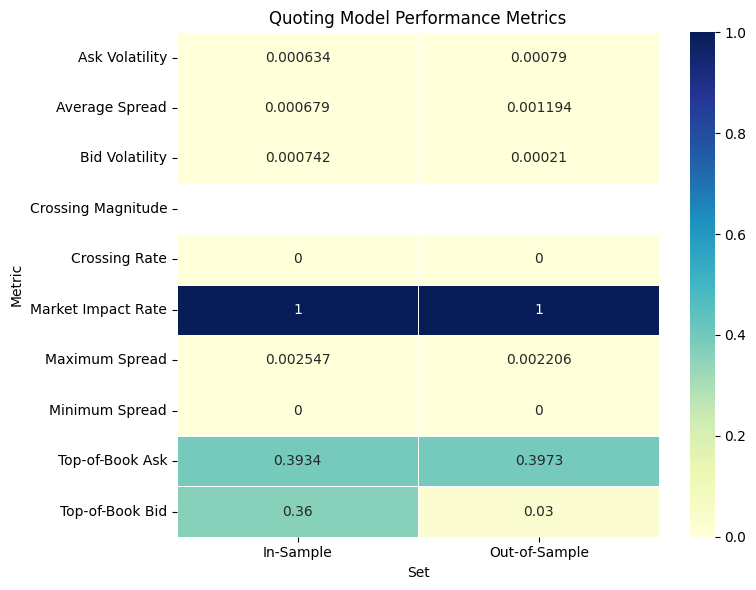

In [24]:
print("=== Evaluation Metrics ===")
display(all_metrics.pivot(index='Metric', columns='Set', values='Value'))

plt.figure(figsize=(8, 6))
sns.heatmap(all_metrics.pivot(index='Metric', columns='Set', values='Value'), annot=True, fmt=".4g", cmap="YlGnBu", linewidth=0.5)
plt.title("Quoting Model Performance Metrics")
plt.tight_layout()
plt.show()

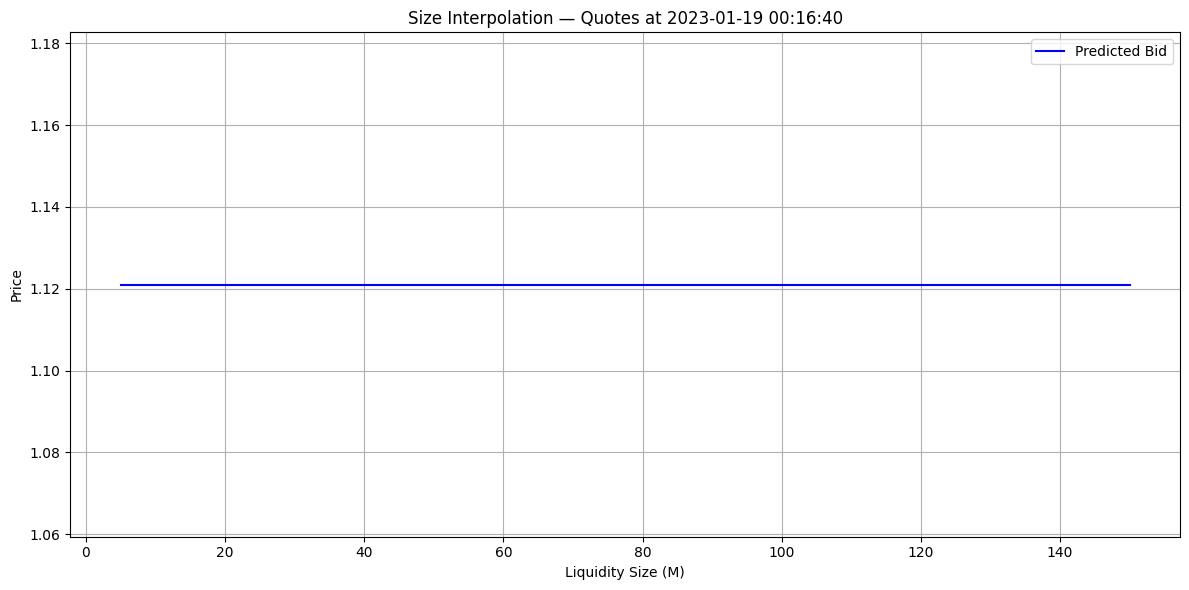

In [25]:
# Pick a stable timestamp from your test data
timestamp = quotes_test.iloc[100]["timestamp"]

evaluate_size_interpolation(
    model_bid=results["bid"]["model"],
    model_ask=results["ask"]["model"],
    training_df=features,
    timestamp=timestamp,
    size_range=range(5, 151)  # 5M to 150M
)

#**Visualizing Mid and Spread Changes Across Time**

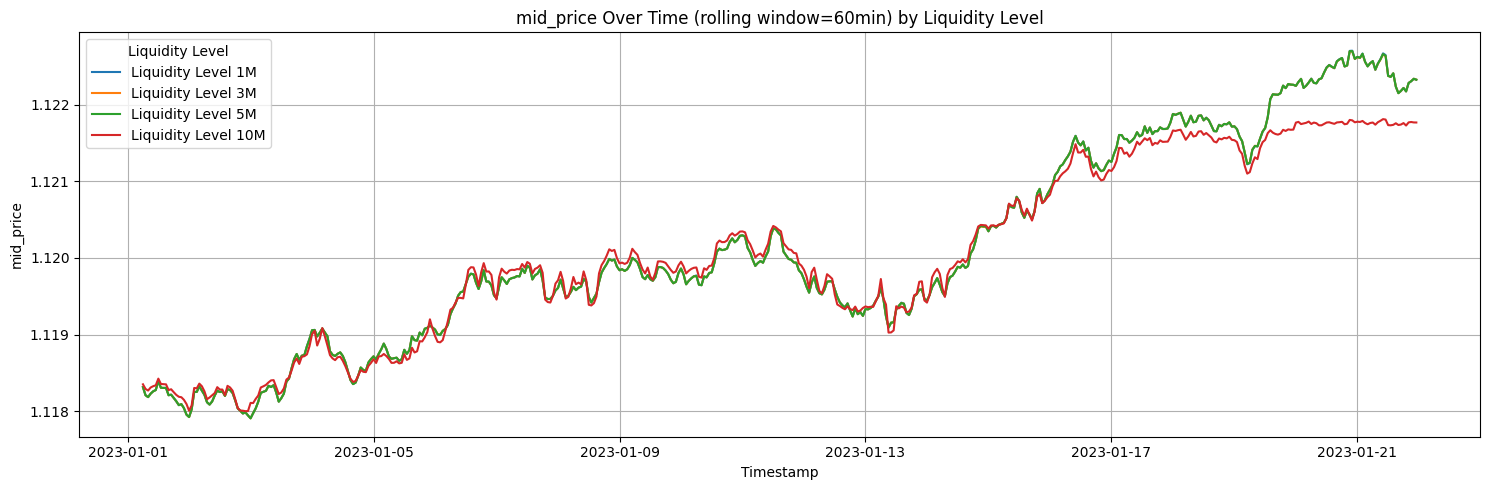

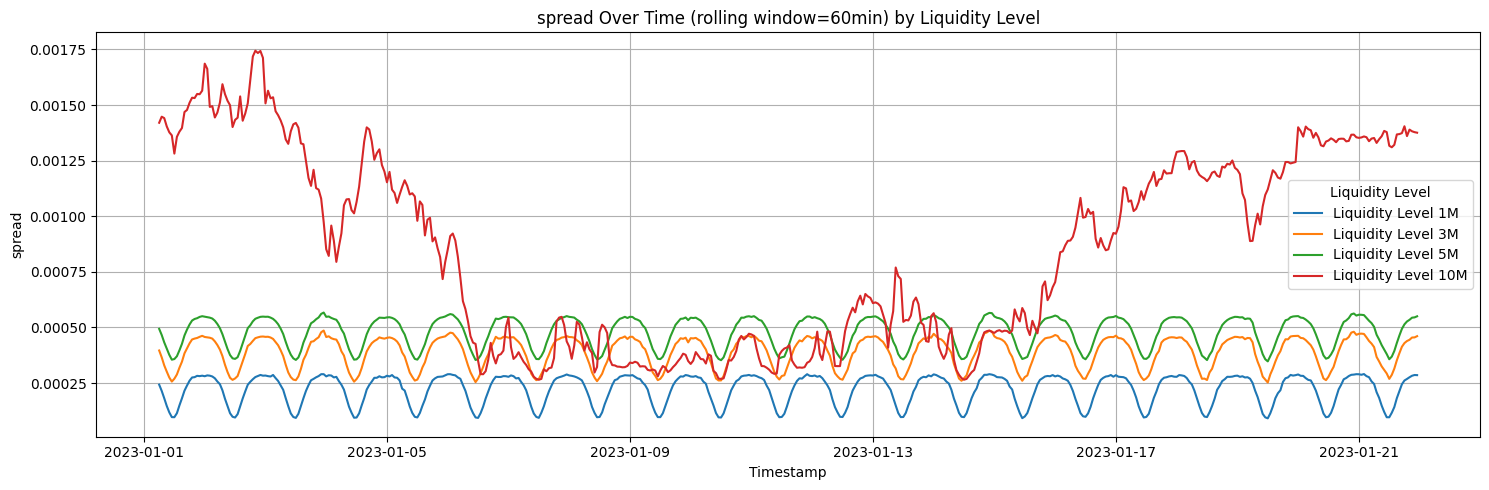

In [26]:
def plot_quote_mid_spread(quotes_df, col_name, levels, rolling_window='5min'):
    """ Plot quote mid and spread over time for different liquidity levels """

    quotes_df['timestamp'] = pd.to_datetime(quotes_df['timestamp'])
    plt.figure(figsize=(15, 5))

    for lvl in levels:
        subset = quotes_df[quotes_df['liquidity_level'] == lvl]

        # Resample and keep only numeric columns
        subset = subset.set_index('timestamp')
        numeric_cols = subset.select_dtypes(include='number').columns
        subset = subset[numeric_cols].resample(rolling_window).mean().dropna().reset_index()

        # Check if col_name is in the result before plotting
        if col_name in subset.columns:
            plt.plot(subset['timestamp'], subset[col_name], label=f'Liquidity Level {lvl}M')

    plt.title(f'{col_name} Over Time (rolling window={rolling_window}) by Liquidity Level')
    plt.xlabel('Timestamp')
    plt.ylabel(col_name)
    plt.legend(title='Liquidity Level')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#levels = [1, 3, 5, 10, 50, 100, 150] # unit in milions
levels = [1, 3, 5, 10] # unit in milions
# Plot Mid Price Over Time by Liquidity Level
plot_quote_mid_spread(hybrid_quotes, col_name='mid_price', levels=levels, rolling_window='60min')
plot_quote_mid_spread(hybrid_quotes, col_name='spread', levels=levels, rolling_window='60min')


#**Visualizing My QUotes with Individual LP Quotes**

<ipython-input-28-c06490bc967c>:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted = df_preprocessed.pivot_table(


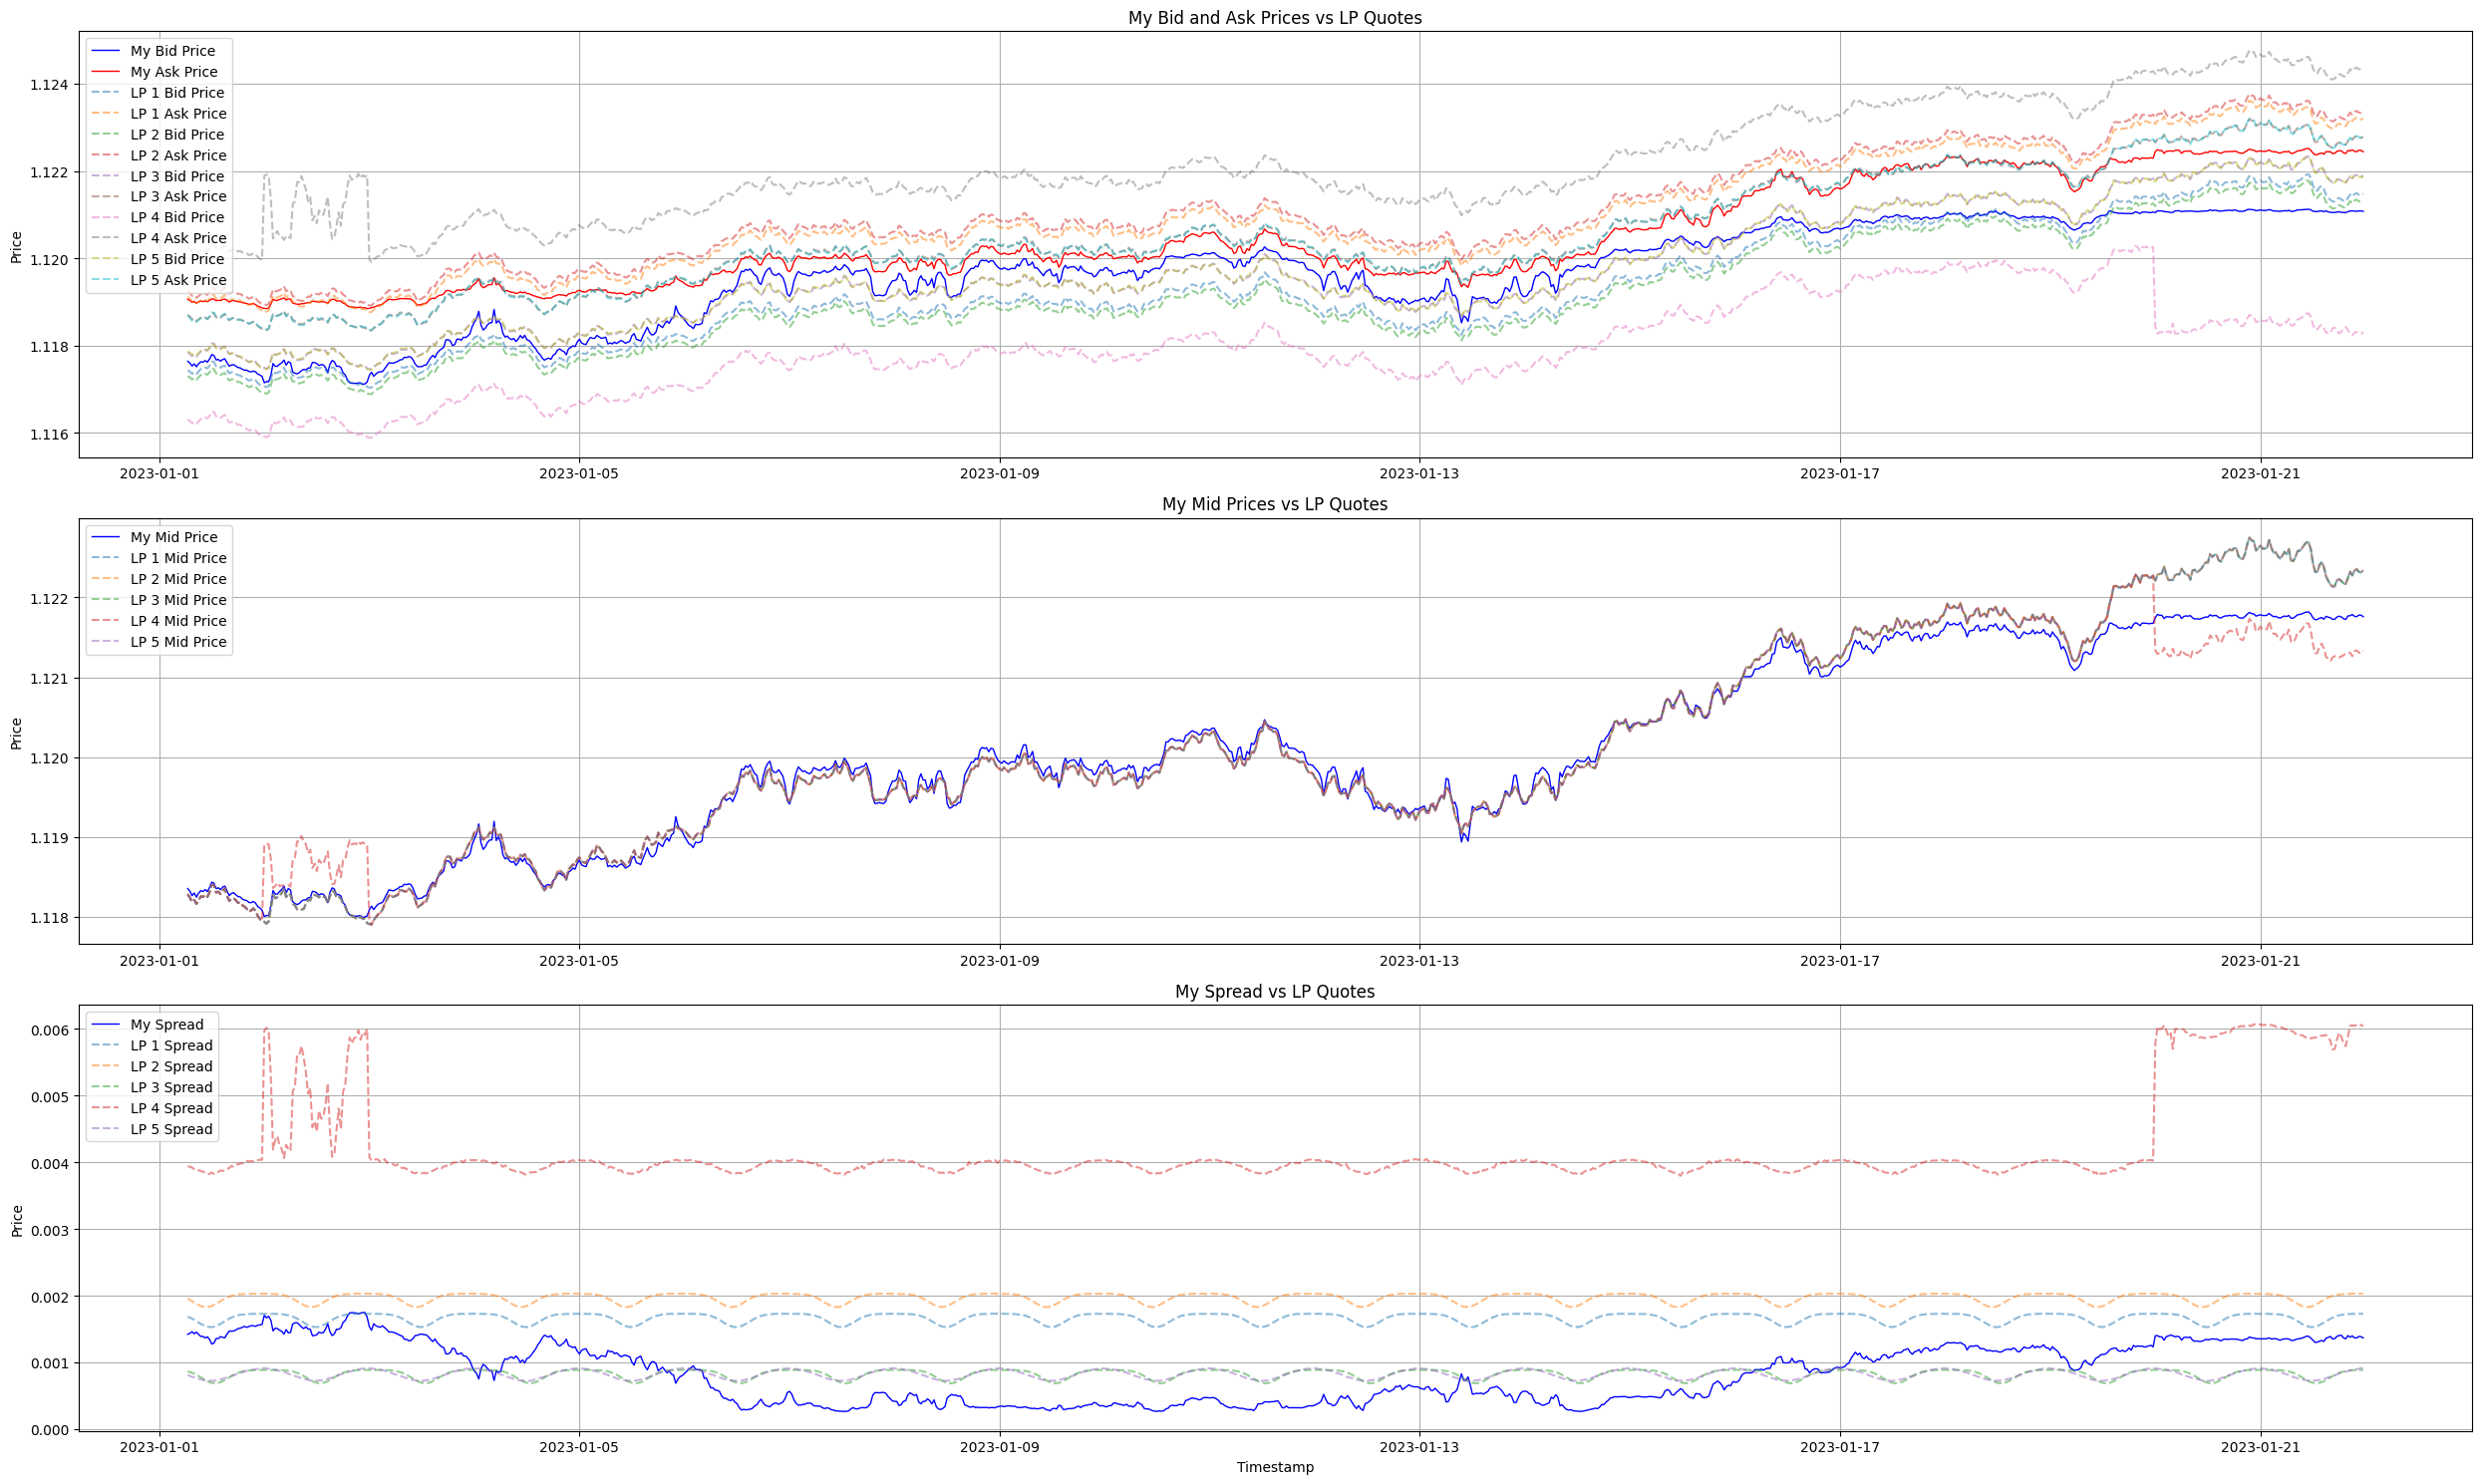

In [28]:
def visualize_quote_prices(hybrid_quotes, df_preprocessed, selected_level):

  quotes_price_selected = hybrid_quotes[hybrid_quotes['liquidity_level'] == selected_level].copy()

  pivoted = df_preprocessed.pivot_table(
      index='timestamp',
      columns=['lp_id', 'side'],
      values='price',
      aggfunc='mean'
  ).reset_index()

  pivoted.columns = ['timestamp' if col[0] == 'timestamp' else f'LP{col[0]}_{col[1]}' for col in pivoted.columns]

  merged = quotes_price_selected.merge(pivoted, on='timestamp', how='inner')

  merged = merged.set_index('timestamp')
  numeric_cols = merged.select_dtypes(include='number').columns
  merged_subset = merged[numeric_cols].resample('30min').mean().dropna().reset_index()

  fig, ax = plt.subplots(3, 1, figsize=(25, 15))
  if 'my_bid' in merged_subset.columns and 'my_ask' in merged_subset.columns:
    ax[0].plot(merged_subset['timestamp'], merged_subset['my_bid'], label='My Bid Price', color='blue', linewidth=1)
    ax[0].plot(merged_subset['timestamp'], merged_subset['my_ask'], label='My Ask Price', color='red', linewidth=1)
    ax[1].plot(merged_subset['timestamp'], (merged_subset['my_bid'] + merged_subset['my_ask'])/2, label='My Mid Price', color='blue', linewidth=1)
    ax[2].plot(merged_subset['timestamp'], merged_subset['my_ask'] - merged_subset['my_bid'], label='My Spread', color='blue', linewidth=1)

  for lp in lp_quotes['lp_id'].unique():
      bid_col = f'LP{lp}_bid'
      ask_col = f'LP{lp}_ask'
      if bid_col in merged_subset.columns and ask_col in merged_subset.columns:
        ax[0].plot(merged_subset['timestamp'], merged_subset[bid_col], label=f'LP {lp} Bid Price', linestyle='--', alpha=0.5)
        ax[0].plot(merged_subset['timestamp'], merged_subset[ask_col], label=f'LP {lp} Ask Price', linestyle='--', alpha=0.5)
        ax[1].plot(merged_subset['timestamp'], (merged_subset[bid_col] + merged_subset[ask_col])/2, label=f'LP {lp} Mid Price', linestyle='--', alpha=0.5)
        ax[2].plot(merged_subset['timestamp'], merged_subset[ask_col] - merged_subset[bid_col], label=f'LP {lp} Spread', linestyle='--', alpha=0.5)
  ax[0].set_title('My Bid and Ask Prices vs LP Quotes')
  ax[1].set_title('My Mid Prices vs LP Quotes')
  ax[2].set_title('My Spread vs LP Quotes')

  for i in range(3):
    ax[i].set_ylabel('Price')
    ax[i].legend()
    ax[i].grid(True)

  plt.xlabel('Timestamp')
  plt.ylabel('Price')
  plt.tight_layout()
  plt.show()

selected_level = 100
visualize_quote_prices(hybrid_quotes, df_preprocessed, selected_level)

#**Future Works**

1- I would train a more robust model with richer data. While current model considers liquidiy levels, but it still lacks of enough generalizibility for robust prediction. With more data (especially over longer time horizons or additional currency pairs), I would train more generalized models that capture regime changes, seasonality, and unexpected market conditions. \\
2- I will stry more advanced models to capture temporal changes more better. Models like light RNN models. \\
3- On idea that I think it's very interesting to apply if data is more richer and wider is that training a model based on reinforcement learning to adjust itself based on market changes.